# Classes

In [ ]:
class Dataset():
    def __init__(self, **kwargs):
        pass
    
    def getData(self, idx):
        pass
        

In [ ]:
from utils import *
from tools import *

class DynamicSimulatedDataset(Dataset):
    def __init__(self, **kwargs):
        x0 = kwargs.pop('x0', (0,0))
        v0 = kwargs.pop('v0', 5)
        a0 = kwargs.pop('a0', 0)
        N = kwargs.pop('N', 150)
        prior = kwargs.pop('prior', (1, 0.009, -0.004))
        dR = kwargs.pop('dR', 0.4)
        dAz = kwargs.pop('dAz', 0.05)
        polynom_noise_ratio = kwargs.pop('polynom_noise_ratio', 0.5)
        seed = kwargs.pop('seed', None)
        self.__generateEgoMotion(x0=np.asarray(x0), v0=v0, a0=a0, path=prior, N=N, dT=0.1)
        self.prior, self.dR, self.dAz, self.polynom_noise_ratio = prior, dR, dAz, polynom_noise_ratio
        x, y = createPolynom(a1=prior[0],a2=prior[1],a3=prior[2],xstart=0,xend=200)
        self.N = N
        
    def getData(self, t):
        pos = [self.t[0,t], self.t[1,t]]
        heading = np.rad2deg(np.arccos(self.R[0,0,t]))
        z,dz = self.__generateData(prior=self.prior, dR=self.dR, dAz=self.dAz, pos=pos, R=self.R[:,:,t], polynom_noise_ratio=self.polynom_noise_ratio, N=100)
        zw, covw = self.__convert2WorldCoordinates(z, dz, self.R[:,:,t], self.t[:,t].reshape(2,1))
        video_data = {"polynom":zw[0:50,:],"dpolynom":covw[0:50,:,:], "other":zw[50:100,:],"dother":covw[50:100,:,:]}
        
        return zw, covw, self.prior, video_data
        
    def __generateData(self, prior, dR, dAz, pos, R, polynom_noise_ratio=0.5, N=100):
        [_,_,x_poly,y_poly,polynom_cov] = generatePolynomNoisyPoints(N=int(polynom_noise_ratio*N),a1=prior[0],a2=prior[1],a3=prior[2],dR=dR,dAz=dAz,pos=pos,R=np.linalg.inv(R))
        [x_noise,y_noise,noise_cov] = generateRandomNoisyPoints(N=int((1-polynom_noise_ratio)*N),xRange=[3,100],yRange=[-40,40],dR=dR,dAz=dAz)
        x_meas = np.concatenate([x_poly, x_noise])
        y_meas = np.concatenate([y_poly, y_noise])
        dz_meas = np.concatenate([polynom_cov, noise_cov])
        z = np.array([x_meas, y_meas]).T
        dz = np.array(dz_meas)
        
        return z,dz
    
     def __convert2WorldCoordinates(self, z, cov, R, t):
        #print(z.shape, cov.shape, R.shape, t.shape)
        zw = np.matmul(R,z.T) + t
        covw = np.matmul(np.matmul(R, cov), R.T)
        
        return zw.T, covw
    
    def __generateEgoMotion(self, x0, v0, a0, path, N, dT):
        dist = np.arange(0,N)*dT*(v0+a0*dT)
        c,b,a = path[0],path[1],path[2]
        x = (np.power(3*a*dist + np.power(b+1,3./2), 2./3)-b-1)/(2*a)
        y = a*x**2+b*x+c - 5
        self.path = np.array([x, y])
        d0 = np.array([1,0]).reshape(1,2)
        di = np.array([np.repeat(1,x.shape), 2*a*x])
        
        angle = np.arctan2(d0[:,0]*di[1,:]-d0[:,1]*di[0,:],d0[:,0]*di[0,:]+d0[:,1]*di[1,:])
       
        self.R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
        self.t = self.path - x0.reshape(2,1)
        
        #self.generateData(prior, dR, dTheta, polynom_noise_ratio, seed):
    

In [ ]:
import numpy as np
import pandas as pd
import json
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap
from pyquaternion import Quaternion

class NuscenesDataset(Dataset):
    def __init__(self, **kwargs):
        directory = kwargs.pop('directory')
        scene_id = kwargs.pop('scene', 5)
        map_name = kwargs.pop('map_name', 'singapore-queenstown')
        self.nusc = NuScenes(version="v1.0-mini", dataroot=directory, verbose=False)
        self.nusc_map = NuScenesMap(dataroot=directory, map_name=map_name)
        #ego_poses = nusc_map_bos.render_egoposes_on_fancy_map(nusc, scene_tokens=[nusc.scene[5]['token']], verbose=False)
        self.rpath = os.path.join(directory, 'sweeps', 'RADAR_FRONT')
        self.cpath = os.path.join(directory, 'sweeps', 'CAM_FRONT')
        self.ego = self.extractEgo(os.path.join(directory, 'v1.0-mini', 'ego_pose.json'))
        self.radar_files = os.listdir(self.rpath)
        self.camera_files = os.listdir(self.cpath)
        self.radar_ts = self.extractTimestamps(self.radar_files)
        self.camera_ts = self.extractTimestamps(self.camera_files)
        
        my_scene = nusc.scene[scene_id]
        first_sample_token = my_scene['first_sample_token']
        my_sample = nusc.get('sample', first_sample_token)
        radar_front_data = nusc.get('sample_data', my_sample['data']['RADAR_FRONT'])
        self.cs_record = nusc.get('calibrated_sensor', radar_front_data['calibrated_sensor_token'])
        
        
    def getData(self, t):
        zw, covw = self.__getTransformedRadarData(t)
        prior = self.__getPrior(t)
        img = self.__getSyncedImage(t)
        trns,rot = self.__getEgoInfo(t)
        video_data = {"pc": pc, "img": img, "prior": prior, "pos": trns}
        return zw, covw, prior, video_data
    
    def __getTransformedRadarData(self, t):
        f = os.path.join(self.rpath, self.radar_files[t])
        pc = RadarPointCloud.from_file(f)
        pc = self.__sensor2WorldCoordinates(t, pc)
        return pc.points.T
        
    def __extractPolynomFromLane(self, lane):
        lane_record = self.nusc_map.get_arcline_path(lane)
        poses = arcline_path_utils.discretize_lane(lane_record, resolution_meters=0.5)
        poses = np.asarray(poses)
        lane = np.polyfit(poses[:,0], poses[:,1], 2)
        poly = np.poly1d(lane) 
        return {"x":poses[:,0], "poly":poly}
    
    def __sensor2EgoCoordinates(self, pc):
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
        pc.translate(np.array(cs_record['translation']))
        
        return pc
    
    def __sensor2WorldCoordinates(self, idx, pc):
        # Stage1: Sensor -> Ego
        pc = self.__sensor2EgoCoordinates(pc)
        # Stage2: Ego -> World
        trns,rot = self.__getEgoInfo(idx)
        pc.rotate(Quaternion(rot).rotation_matrix)
        pc.translate(np.array(trns))
        
        return pc
        
    def __extractEgo(self, file):
        with open(file) as ego_file:
            ego = pd.read_json(ego_file,convert_dates=False)

        ego.reset_index(level=0, inplace=True)
        return ego
        
    def __extractTimestamps(self, filenames):
        ts = []
        for filename in filenames:
            ts.append(np.int64(filename.split('_')[-1].split('.')[0]))
            
        df = pd.DataFrame({'timestamp':ts})
        return df
    
    def __getEgoInfo(self, i):
        ts = self.radar_ts.iloc[i].values[0] #take timestamp from radar
        eidx = (self.ego['timestamp']-ts).abs().argsort()[0]
        trns = self.ego.iloc[eidx]["translation"]
        rot = self.ego.iloc[eidx]["rotation"]
        return trns,rot
 
    def __getPrior(self, i):
        ts = self.radar_ts.iloc[i].values[0] #take timestamp from radar
        eidx = (self.ego['timestamp']-ts).abs().argsort()[0]
        trns = self.ego.iloc[eidx]["translation"]
        lanes = []
        #closest_lane = self.nusc_map.get_closest_lane(trns[0], trns[1], radius=2)
        #incoming_lane = self.nusc_map.get_incoming_lane_ids(closest_lane)
        #outgoing_lane = self.nusc_map.get_outgoing_lane_ids(closest_lane)
        lane_ids = self.nusc_map.get_records_in_radius(trns[0], trns[1], 20, ['lane', 'lane_connector'])
        nearby_lanes = lane_ids['lane'] + lane_ids['lane_connector']

        for lane in nearby_lanes:
            lanes.append(self.extractPolynomFromLane(lane))
            
        return trns[0],lanes
        
    def __getRadarSweep(self, i):
        f = os.path.join(self.rpath, self.radar_files[i])
        pc = RadarPointCloud.from_file(f)
        pc = pc.points.T
        
        return pc
        
    def __getSyncedImage(self, i):
        ts = self.radar_ts.iloc[i].values[0] #take timestamp from radar
        cidx = (self.camera_ts['timestamp']-ts).abs().argsort()[0]
        img = mpimg.imread(os.path.join(self.cpath, self.camera_files[cidx]))
        
        return img

In [2]:
from utils import *
from tracker import Tracker
from tools import *
from video import TrackVideo

class DynamicSimulation():
    def __init__(self, x0=(0,0), v0=5, a0=0, N=150, prior=(1, 0.009, -0.004), dR=0.4, dAz=0.05, polynom_noise_ratio=0.5, seed=None):
        self.generateEgoMotion(x0=np.asarray(x0), v0=v0, a0=a0, path=prior, N=N, dT=0.1)
        self.prior, self.dR, self.dAz, self.polynom_noise_ratio = prior, dR, dAz, polynom_noise_ratio
        x, y = createPolynom(a1=prior[0],a2=prior[1],a3=prior[2],xstart=0,xend=200)
        self.video = TrackVideo(x,y)
        self.N = N
        
    def run(self):
        model = Tracker()
        for t in range(0,self.N):
            print(f"frame {t}")
            pos = [self.t[0,t], self.t[1,t]]
            heading = np.rad2deg(np.arccos(self.R[0,0,t]))
            z,dz = self.generateData(prior=self.prior, dR=self.dR, dAz=self.dAz, pos=pos, R=self.R[:,:,t], polynom_noise_ratio=self.polynom_noise_ratio, N=100)
            zw, covw = self.convert2WorldCoordinates(z, dz, self.R[:,:,t], self.t[:,t].reshape(2,1))
            self.video_measurements = {"polynom":zw[0:50,:],"dpolynom":covw[0:50,:,:],
                    "other":zw[50:100,:],"dother":covw[50:100,:,:]}
            points, polynoms = model.run(zw,covw,self.prior)
            self.video.save(t, self.video_measurements, points, polynoms, model.getDebugInfo(), pos=pos, heading=heading)
        
    def generateData(self, prior, dR, dAz, pos, R, polynom_noise_ratio=0.5, N=100):
        [_,_,x_poly,y_poly,polynom_cov] = generatePolynomNoisyPoints(N=int(polynom_noise_ratio*N),a1=prior[0],a2=prior[1],a3=prior[2],dR=dR,dAz=dAz,pos=pos,R=np.linalg.inv(R))
        [x_noise,y_noise,noise_cov] = generateRandomNoisyPoints(N=int((1-polynom_noise_ratio)*N),xRange=[3,100],yRange=[-40,40],dR=dR,dAz=dAz)
        x_meas = np.concatenate([x_poly, x_noise])
        y_meas = np.concatenate([y_poly, y_noise])
        dz_meas = np.concatenate([polynom_cov, noise_cov])
        z = np.array([x_meas, y_meas]).T
        dz = np.array(dz_meas)
        
        return z,dz
        
    def convert2WorldCoordinates(self, z, cov, R, t):
        #print(z.shape, cov.shape, R.shape, t.shape)
        zw = np.matmul(R,z.T) + t
        covw = np.matmul(np.matmul(R, cov), R.T)
        
        return zw.T, covw
    
    def generateEgoMotion(self, x0, v0, a0, path, N, dT):
        dist = np.arange(0,N)*dT*(v0+a0*dT)
        c,b,a = path[0],path[1],path[2]
        x = (np.power(3*a*dist + np.power(b+1,3./2), 2./3)-b-1)/(2*a)
        y = a*x**2+b*x+c - 5
        self.path = np.array([x, y])
        d0 = np.array([1,0]).reshape(1,2)
        di = np.array([np.repeat(1,x.shape), 2*a*x])
        
        angle = np.arctan2(d0[:,0]*di[1,:]-d0[:,1]*di[0,:],d0[:,0]*di[0,:]+d0[:,1]*di[1,:])
       
        self.R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
        self.t = self.path - x0.reshape(2,1)
        
        #self.generateData(prior, dR, dTheta, polynom_noise_ratio, seed):

## Dynamic simulation

[ -4.          -3.99650872  -3.99500252  -3.99549327  -3.99799302
  -4.00251395  -4.00906842  -4.01766893  -4.02832816  -4.04105895
  -4.0558743   -4.0727874   -4.09181161  -4.11296046  -4.13624767
  -4.16168717  -4.18929305  -4.2190796   -4.25106133  -4.28525294
  -4.32166933  -4.36032563  -4.40123718  -4.44441952  -4.48988847
  -4.53766002  -4.58775043  -4.64017621  -4.69495409  -4.75210107
  -4.81163441  -4.87357163  -4.93793051  -5.00472913  -5.07398583
  -5.14571925  -5.21994833  -5.29669232  -5.37597076  -5.45780352
  -5.54221081  -5.62921315  -5.71883142  -5.81108685  -5.90600102
  -6.00359589  -6.1038938   -6.20691747  -6.31269002  -6.421235
  -6.53257635  -6.64673846  -6.76374617  -6.88362474  -7.00639995
  -7.13209802  -7.26074568  -7.39237018  -7.52699926  -7.66466123
  -7.80538495  -7.94919982  -8.09613588  -8.24622372  -8.39949458
  -8.55598035  -8.71571356  -8.87872742  -9.04505588  -9.21473357
  -9.3877959   -9.56427904  -9.74421995  -9.92765644 -10.11462715
 -10.3051716

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 2
0.9975050385239853 100.99750503852398
(50,) (50,)
[[ 0.99750504]
 [-3.99500252]] [[ 0.99996816  0.00797979]
 [-0.00797979  0.99996816]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 182
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 1
frame 3
1.4977505583396167 101.49775055833962
(50,) (50,)
[[ 1.49775056]
 [-3.99549327]] [[ 0.99992822  0.01198114]
 [-0.01198114  0.99992822]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 251
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 1
frame 4
1.999002078421616 101.99900207842161
(50,) (50,)
[[ 1.99900208]
 [-3.99799302]] [[ 0.99987215  0.01598997]
 [-0.01598997  0.99987215]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 319
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 2
frame 5
2.5012677402478785 102.50126774024788
(50,) (50,)
[[ 2.50126774]
 [-4.00251395]] [[ 0.99979986  0.02000614]
 [-0.02000614  0.99979986]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 310
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 1
frame 6
3.0045558013055973 103.0045558013056
(50,) (50,)
[[ 3.0045558 ]
 [-4.00906842]] [[ 0.99971125  0.02402951]
 [-0.02402951  0.99971125]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 314
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 7
3.508874637467241 103.50887463746724
(50,) (50,)
[[ 3.50887464]
 [-4.01766893]] [[ 0.99960624  0.02805994]
 [-0.02805994  0.99960624]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
len(unique_polynoms) 2
frame 8
4.0142327454302515 104.01423274543025
(50,) (50,)
[[ 4.01423275]
 [-4.02832816]] [[ 0.99948475  0.03209732]
 [-0.03209732  0.99948475]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 307
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 9
4.520638745222405 104.5206387452224
(50,) (50,)
[[ 4.52063875]
 [-4.04105895]] [[ 0.99934668  0.03614148]
 [-0.03614148  0.99934668]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 330
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2
len(unique_polynoms) 3
frame 10
5.028101382775235 105.02810138277523
(50,) (50,)
[[ 5.02810138]
 [-4.0558743 ]] [[ 0.99919196  0.04019231]
 [-0.04019231  0.99919196]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 328
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 3
frame 11
5.5366295325676855 105.53662953256769
(50,) (50,)
[[ 5.53662953]
 [-4.0727874 ]] [[ 0.9990205   0.04424965]
 [-0.04424965  0.9990205 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  1
len(unique_polynoms) 3
frame 12
6.046232200342296 106.0462322003423
(50,) (50,)
[[ 6.0462322 ]
 [-4.09181161]] [[ 0.99883223  0.04831337]
 [-0.04831337  0.99883223]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 324
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 3
frame 13
6.5569185258965295 106.55691852589653
(50,) (50,)
[[ 6.55691853]
 [-4.11296046]] [[ 0.99862705  0.05238333]
 [-0.05238333  0.99862705]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 318
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
len(unique_polynoms) 2
frame 14
7.068697785951885 107.06869778595188
(50,) (50,)
[[ 7.06869779]
 [-4.13624767]] [[ 0.9984049   0.05645938]
 [-0.05645938  0.9984049 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 311
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
len(unique_polynoms) 2
frame 15
7.581579397103064 107.58157939710307
(50,) (50,)
[[ 7.5815794 ]
 [-4.16168717]] [[ 0.99816569  0.06054138]
 [-0.06054138  0.99816569]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 306
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  2
len(unique_polynoms) 3
frame 16
8.095572918850587 108.09557291885059
(50,) (50,)
[[ 8.09557292]
 [-4.18929305]] [[ 0.99790935  0.06462918]
 [-0.06462918  0.99790935]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 304
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1
len(unique_polynoms) 3
frame 17
8.610688056719177 108.61068805671917
(50,) (50,)
[[ 8.61068806]
 [-4.2190796 ]] [[ 0.9976358   0.06872265]
 [-0.06872265  0.9976358 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 297
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 18
9.126934665465338 109.12693466546534
(50,) (50,)
[[ 9.12693467]
 [-4.25106133]] [[ 0.99734498  0.07282162]
 [-0.07282162  0.99734498]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 303
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  2
Updating extended object track =  3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 2
frame 19
9.644322752377088 109.6443227523771
(50,) (50,)
[[ 9.64432275]
 [-4.28525294]] [[ 0.99703681  0.07692596]
 [-0.07692596  0.99703681]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 289
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 20
10.162862480669194 110.16286248066919
(50,) (50,)
[[10.16286248]
 [-4.32166933]] [[ 0.99671121  0.08103551]
 [-0.08103551  0.99671121]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 303
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
i_trk 0 self.frame_idx 21 trk.getLastUpdateFrameIdx() 16
len(unique_polynoms) 3
frame 21
10.682564172977262 110.68256417297727
(50,) (50,)
[[10.68256417]
 [-4.36032563]] [[ 0.99636813  0.08515013]
 [-0.08515013  0.99636813]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 326
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
len(unique_polynoms) 2
frame 22
11.203438314954406 111.20343831495441
(50,) (50,)
[[11.20343831]
 [-4.40123718]] [[ 0.99600749  0.08926967]
 [-0.08926967  0.99600749]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 332
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
len(unique_polynoms) 2
frame 23
11.725495558974021 111.72549555897402
(50,) (50,)
[[11.72549556]
 [-4.44441952]] [[ 0.99562923  0.09339397]
 [-0.09339397  0.99562923]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 328
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 2
frame 24
12.248746727942711 112.24874672794272
(50,) (50,)
[[12.24874673]
 [-4.48988847]] [[ 0.99523328  0.09752288]
 [-0.09752288  0.99523328]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 321
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
len(unique_polynoms) 3
frame 25
12.773202819227294 112.7732028192273
(50,) (50,)
[[12.77320282]
 [-4.53766002]] [[ 0.99481958  0.10165626]
 [-0.10165626  0.99481958]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 313
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0
len(unique_polynoms) 2
frame 26
13.298875008700278 113.29887500870028
(50,) (50,)
[[13.29887501]
 [-4.58775043]] [[ 0.99438807  0.10579394]
 [-0.10579394  0.99438807]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 311
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 27
13.825774654908098 113.8257746549081
(50,) (50,)
[[13.82577465]
 [-4.64017621]] [[ 0.99393869  0.10993578]
 [-0.10993578  0.99393869]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 314
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 28
14.353913303366717 114.35391330336671
(50,) (50,)
[[14.3539133 ]
 [-4.69495409]] [[ 0.99347138  0.11408162]
 [-0.11408162  0.99347138]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 311
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
len(unique_polynoms) 2
frame 29
14.8833026909896 114.8833026909896
(50,) (50,)
[[14.88330269]
 [-4.75210107]] [[ 0.99298608  0.1182313 ]
 [-0.1182313   0.99298608]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 313
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 30
15.413954750652852 115.41395475065285
(50,) (50,)
[[15.41395475]
 [-4.81163441]] [[ 0.99248274  0.12238467]
 [-0.12238467  0.99248274]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 314
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
len(unique_polynoms) 1
frame 31
15.945881615903115 115.94588161590312
(50,) (50,)
[[15.94588162]
 [-4.87357163]] [[ 0.9919613   0.12654158]
 [-0.12654158  0.9919613 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 317
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 2
frame 32
16.479095625813304 116.4790956258133
(50,) (50,)
[[16.47909563]
 [-4.93793051]] [[ 0.99142172  0.13070187]
 [-0.13070187  0.99142172]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 310
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
len(unique_polynoms) 1
frame 33
17.01360932999249 117.01360932999249
(50,) (50,)
[[17.01360933]
 [-5.00472913]] [[ 0.99086393  0.13486537]
 [-0.13486537  0.99086393]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 34
17.549435493755496 117.5494354937555
(50,) (50,)
[[17.54943549]
 [-5.07398583]] [[ 0.9902879   0.13903195]
 [-0.13903195  0.9902879 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 321
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
len(unique_polynoms) 2
frame 35
18.086587103458896 118.0865871034589
(50,) (50,)
[[18.0865871 ]
 [-5.14571925]] [[ 0.98969356  0.14320143]
 [-0.14320143  0.98969356]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 317
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
i_trk 0 self.frame_idx 36 trk.getLastUpdateFrameIdx() 31
len(unique_polynoms) 1
frame 36
18.62507737200973 118.62507737200973
(50,) (50,)
[[18.62507737]
 [-5.21994833]] [[ 0.98908089  0.14737366]
 [-0.14737366  0.98908089]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 319
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 37
19.164919744554197 119.1649197445542
(50,) (50,)
[[19.16491974]
 [-5.29669232]] [[ 0.98844982  0.15154849]
 [-0.15154849  0.98844982]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 329
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 2
frame 38
19.706127904353373 119.70612790435337
(50,) (50,)
[[19.7061279 ]
 [-5.37597076]] [[ 0.98780033  0.15572576]
 [-0.15572576  0.98780033]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 39
20.248715778853633 120.24871577885364
(50,) (50,)
[[20.24871578]
 [-5.45780352]] [[ 0.98713236  0.1599053 ]
 [-0.1599053   0.98713236]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 323
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
len(unique_polynoms) 2
frame 40
20.792697545959914 120.79269754595991
(50,) (50,)
[[20.79269755]
 [-5.54221081]] [[ 0.98644588  0.16408697]
 [-0.16408697  0.98644588]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 320
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 41
21.33808764051999 121.33808764051999
(50,) (50,)
[[21.33808764]
 [-5.62921315]] [[ 0.98574084  0.1682706 ]
 [-0.1682706   0.98574084]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 319
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 42
21.884900761028863 121.88490076102886
(50,) (50,)
[[21.88490076]
 [-5.71883142]] [[ 0.98501722  0.17245603]
 [-0.17245603  0.98501722]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 314
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 2
frame 43
22.433151876562125 122.43315187656212
(50,) (50,)
[[22.43315188]
 [-5.81108685]] [[ 0.98427497  0.17664312]
 [-0.17664312  0.98427497]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 324
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
len(unique_polynoms) 3
frame 44
22.982856233948535 122.98285623394854
(50,) (50,)
[[22.98285623]
 [-5.90600102]] [[ 0.98351406  0.1808317 ]
 [-0.1808317   0.98351406]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 325
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
len(unique_polynoms) 2
frame 45
23.5340293651915 123.5340293651915
(50,) (50,)
[[23.53402937]
 [-6.00359589]] [[ 0.98273445  0.18502161]
 [-0.18502161  0.98273445]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 314
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 2
frame 46
24.086687095150562 124.08668709515057
(50,) (50,)
[[24.0866871]
 [-6.1038938]] [[ 0.98193612  0.18921271]
 [-0.18921271  0.98193612]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 311
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
len(unique_polynoms) 1
frame 47
24.640845549494014 124.64084554949402
(50,) (50,)
[[24.64084555]
 [-6.20691747]] [[ 0.98111904  0.19340482]
 [-0.19340482  0.98111904]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 313
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 4
frame 48
25.19652116293461 125.1965211629346
(50,) (50,)
[[25.19652116]
 [-6.31269002]] [[ 0.98028318  0.19759781]
 [-0.19759781  0.98028318]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 307
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 49
25.753730687760783 125.75373068776078
(50,) (50,)
[[25.75373069]
 [-6.421235  ]] [[ 0.9794285  0.2017915]
 [-0.2017915  0.9794285]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 317
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
len(unique_polynoms) 1
frame 50
26.31249120267659 126.3124912026766
(50,) (50,)
[[26.3124912 ]
 [-6.53257635]] [[ 0.97855499  0.20598576]
 [-0.20598576  0.97855499]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 322
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 51
26.872820121964306 126.87282012196431
(50,) (50,)
[[26.87282012]
 [-6.64673846]] [[ 0.97766262  0.21018041]
 [-0.21018041  0.97766262]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 319
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
len(unique_polynoms) 1
frame 52
27.434735204984072 127.43473520498407
(50,) (50,)
[[27.4347352 ]
 [-6.76374617]] [[ 0.97675136  0.21437532]
 [-0.21437532  0.97675136]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 319
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


i_trk 0 self.frame_idx 53 trk.getLastUpdateFrameIdx() 48
i_trk 1 self.frame_idx 53 trk.getLastUpdateFrameIdx() 48
len(unique_polynoms) 0
frame 53
27.998254566026322 127.99825456602632
(50,) (50,)
[[27.99825457]
 [-6.88362474]] [[ 0.9758212   0.21857032]
 [-0.21857032  0.9758212 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 320
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
len(unique_polynoms) 2
frame 54
28.56339668453288 128.56339668453288
(50,) (50,)
[[28.56339668]
 [-7.00639995]] [[ 0.97487211  0.22276527]
 [-0.22276527  0.97487211]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 310
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
len(unique_polynoms) 1
frame 55
29.130180415704185 129.1301804157042
(50,) (50,)
[[29.13018042]
 [-7.13209802]] [[ 0.97390408  0.22696001]
 [-0.22696001  0.97390408]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 325
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
len(unique_polynoms) 3
frame 56
29.698625001510532 129.69862500151052
(50,) (50,)
[[29.698625  ]
 [-7.26074568]] [[ 0.97291708  0.2311544 ]
 [-0.2311544   0.97291708]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 314
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 57
30.268750082126523 130.26875008212653
(50,) (50,)
[[30.26875008]
 [-7.39237018]] [[ 0.9719111   0.23534827]
 [-0.23534827  0.9719111 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 318
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  0
len(unique_polynoms) 2
frame 58
30.840575707808917 130.8405757078089
(50,) (50,)
[[30.84057571]
 [-7.52699926]] [[ 0.97088613  0.2395415 ]
 [-0.2395415   0.97088613]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 315
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 59
31.41412235123929 131.41412235123929
(50,) (50,)
[[31.41412235]
 [-7.66466123]] [[ 0.96984214  0.24373392]
 [-0.24373392  0.96984214]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 322
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2
len(unique_polynoms) 2
frame 60
31.989410920353926 131.98941092035392
(50,) (50,)
[[31.98941092]
 [-7.80538495]] [[ 0.96877913  0.24792539]
 [-0.24792539  0.96877913]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 324
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  3
len(unique_polynoms) 2
frame 61
32.56646277168504 132.56646277168505
(50,) (50,)
[[32.56646277]
 [-7.94919982]] [[ 0.96769708  0.25211577]
 [-0.25211577  0.96769708]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  0
len(unique_polynoms) 2
frame 62
33.14529972423848 133.14529972423847
(50,) (50,)
[[33.14529972]
 [-8.09613588]] [[ 0.96659598  0.25630491]
 [-0.25630491  0.96659598]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 307
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  3
len(unique_polynoms) 2
frame 63
33.725944073934876 133.72594407393487
(50,) (50,)
[[33.72594407]
 [-8.24622372]] [[ 0.96547583  0.26049267]
 [-0.26049267  0.96547583]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 319
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 2
frame 64
34.30841860864242 134.30841860864243
(50,) (50,)
[[34.30841861]
 [-8.39949458]] [[ 0.9643366   0.26467891]
 [-0.26467891  0.9643366 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 321
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
len(unique_polynoms) 3
frame 65
34.8927466238317 134.8927466238317
(50,) (50,)
[[34.89274662]
 [-8.55598035]] [[ 0.96317829  0.26886349]
 [-0.26886349  0.96317829]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 318
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  3
len(unique_polynoms) 2
frame 66
35.47895193888419 135.4789519388842
(50,) (50,)
[[35.47895194]
 [-8.71571356]] [[ 0.9620009   0.27304627]
 [-0.27304627  0.9620009 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 319
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 2
frame 67
36.06705891408876 136.06705891408876
(50,) (50,)
[[36.06705891]
 [-8.87872742]] [[ 0.96080442  0.27722712]
 [-0.27722712  0.96080442]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 317
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  0
len(unique_polynoms) 3
frame 68
36.657092468361974 136.65709246836198
(50,) (50,)
[[36.65709247]
 [-9.04505588]] [[ 0.95958883  0.28140589]
 [-0.28140589  0.95958883]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 304
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
len(unique_polynoms) 2
frame 69
37.249078097730454 137.24907809773046
(50,) (50,)
[[37.2490781 ]
 [-9.21473357]] [[ 0.95835414  0.28558247]
 [-0.28558247  0.95835414]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 300
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  0
len(unique_polynoms) 3
frame 70
37.843041894616306 137.8430418946163
(50,) (50,)
[[37.84304189]
 [-9.3877959 ]] [[ 0.95710034  0.2897567 ]
 [-0.2897567   0.95710034]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 294
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 71
38.439010567968865 138.43901056796886
(50,) (50,)
[[38.43901057]
 [-9.56427904]] [[ 0.95582742  0.29392848]
 [-0.29392848  0.95582742]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 307
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
len(unique_polynoms) 1
frame 72
39.03701146428873 139.03701146428872
(50,) (50,)
[[39.03701146]
 [-9.74421995]] [[ 0.95453537  0.29809767]
 [-0.29809767  0.95453537]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 302
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


i_trk 1 self.frame_idx 73 trk.getLastUpdateFrameIdx() 68
len(unique_polynoms) 0
frame 73
39.637072589593714 139.6370725895937
(50,) (50,)
[[39.63707259]
 [-9.92765644]] [[ 0.95322421  0.30226414]
 [-0.30226414  0.95322421]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 311
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  0
len(unique_polynoms) 3
frame 74
40.23922263237878 140.23922263237878
(50,) (50,)
[[ 40.23922263]
 [-10.11462715]] [[ 0.95189391  0.30642777]
 [-0.30642777  0.95189391]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 312
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  1
len(unique_polynoms) 2
frame 75
40.843490987626005 140.843490987626
(50,) (50,)
[[ 40.84349099]
 [-10.30517161]] [[ 0.95054449  0.31058844]
 [-0.31058844  0.95054449]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 313
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
len(unique_polynoms) 1
frame 76
41.4499077819246 141.4499077819246
(50,) (50,)
[[ 41.44990778]
 [-10.49933025]] [[ 0.94917592  0.31474604]
 [-0.31474604  0.94917592]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 309
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
len(unique_polynoms) 1
frame 77
42.05850389976434 142.05850389976433
(50,) (50,)
[[ 42.0585039 ]
 [-10.69714447]] [[ 0.94778822  0.31890044]
 [-0.31890044  0.94778822]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 320
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  0
len(unique_polynoms) 3
frame 78
42.66931101107098 142.669311011071
(50,) (50,)
[[ 42.66931101]
 [-10.89865661]] [[ 0.94638138  0.32305153]
 [-0.32305153  0.94638138]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3
len(unique_polynoms) 3
frame 79
43.28236160005657 143.28236160005656
(50,) (50,)
[[ 43.2823616 ]
 [-11.10391005]] [[ 0.94495539  0.32719921]
 [-0.32719921  0.94495539]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 309
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
len(unique_polynoms) 1
frame 80
43.89768899546269 143.8976889954627
(50,) (50,)
[[ 43.897689 ]
 [-11.3129492]] [[ 0.94351024  0.33134335]
 [-0.33134335  0.94351024]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 308
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  1
len(unique_polynoms) 3
frame 81
44.51532740228046 144.51532740228046
(50,) (50,)
[[ 44.5153274 ]
 [-11.52581955]] [[ 0.94204595  0.33548387]
 [-0.33548387  0.94204595]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 306
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
len(unique_polynoms) 1
frame 82
45.13531193503703 145.13531193503704
(50,) (50,)
[[ 45.13531194]
 [-11.74256773]] [[ 0.9405625   0.33962065]
 [-0.33962065  0.9405625 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 307
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
len(unique_polynoms) 1
frame 83
45.75767865274473 145.75767865274474
(50,) (50,)
[[ 45.75767865]
 [-11.96324151]] [[ 0.93905988  0.3437536 ]
 [-0.3437536   0.93905988]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 338
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
i_trk 2 self.frame_idx 84 trk.getLastUpdateFrameIdx() 79
len(unique_polynoms) 2
frame 84
46.38246459561672 146.3824645956167
(50,) (50,)
[[ 46.3824646 ]
 [-12.18788991]] [[ 0.9375381   0.34788262]
 [-0.34788262  0.9375381 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 331
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 85
47.00970782365967 147.00970782365965
(50,) (50,)
[[ 47.00970782]
 [-12.41656315]] [[ 0.93599714  0.35200762]
 [-0.35200762  0.93599714]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 327
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
len(unique_polynoms) 1
frame 86
47.63944745726357 147.63944745726357
(50,) (50,)
[[ 47.63944746]
 [-12.64931279]] [[ 0.93443699  0.3561285 ]
 [-0.3561285   0.93443699]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 309
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 87
48.27172371991718 148.2717237199172
(50,) (50,)
[[ 48.27172372]
 [-12.88619173]] [[ 0.93285766  0.36024518]
 [-0.36024518  0.93285766]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 305
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 1
frame 88
48.90657798318769 148.90657798318767
(50,) (50,)
[[ 48.90657798]
 [-13.12725428]] [[ 0.93125912  0.36435758]
 [-0.36435758  0.93125912]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 324
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
i_trk 0 self.frame_idx 89 trk.getLastUpdateFrameIdx() 84
len(unique_polynoms) 1
frame 89
49.544052814114394 149.5440528141144
(50,) (50,)
[[ 49.54405281]
 [-13.3725562 ]] [[ 0.92964138  0.36846561]
 [-0.36846561  0.92964138]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 320
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


i_trk 2 self.frame_idx 90 trk.getLastUpdateFrameIdx() 85
len(unique_polynoms) 1
frame 90
50.184192025177595 150.1841920251776
(50,) (50,)
[[ 50.18419203]
 [-13.62215479]] [[ 0.92800441  0.37256921]
 [-0.37256921  0.92800441]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 325
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
len(unique_polynoms) 2
frame 91
50.82704072701739 150.8270407270174
(50,) (50,)
[[ 50.82704073]
 [-13.87610891]] [[ 0.9263482  0.3766683]
 [-0.3766683  0.9263482]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 92
51.47264538409068 151.4726453840907
(50,) (50,)
[[ 51.47264538]
 [-14.13447908]] [[ 0.92467274  0.38076282]
 [-0.38076282  0.92467274]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 310
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 2
frame 93
52.12105387347092 152.1210538734709
(50,) (50,)
[[ 52.12105387]
 [-14.39732754]] [[ 0.92297801  0.38485269]
 [-0.38485269  0.92297801]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 319
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 94
52.77231554701169 152.7723155470117
(50,) (50,)
[[ 52.77231555]
 [-14.66471831]] [[ 0.92126399  0.38893787]
 [-0.38893787  0.92126399]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 327
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
len(unique_polynoms) 1
frame 95
53.42648129711415 153.42648129711415
(50,) (50,)
[[ 53.4264813 ]
 [-14.93671728]] [[ 0.91953065  0.3930183 ]
 [-0.3930183   0.91953065]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 329
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
len(unique_polynoms) 2
frame 96
54.083603626359135 154.08360362635915
(50,) (50,)
[[ 54.08360363]
 [-15.21339229]] [[ 0.91777798  0.39709392]
 [-0.39709392  0.91777798]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 317
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
len(unique_polynoms) 1
frame 97
54.74373672128703 154.74373672128704
(50,) (50,)
[[ 54.74373672]
 [-15.49481321]] [[ 0.91600594  0.4011647 ]
 [-0.4011647   0.91600594]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 328
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 2
frame 98
55.40693653063394 155.40693653063394
(50,) (50,)
[[ 55.40693653]
 [-15.78105203]] [[ 0.9142145  0.4052306]
 [-0.4052306  0.9142145]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 340
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
len(unique_polynoms) 2
frame 99
56.073260848360064 156.07326084836006
(50,) (50,)
[[ 56.07326085]
 [-16.07218298]] [[ 0.91240364  0.40929158]
 [-0.40929158  0.91240364]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 330
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 100
56.74276940183666 156.74276940183665
(50,) (50,)
[[ 56.7427694 ]
 [-16.36828259]] [[ 0.91057331  0.41334761]
 [-0.41334761  0.91057331]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 323
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 101
57.41552394559206 157.41552394559204
(50,) (50,)
[[ 57.41552395]
 [-16.66942984]] [[ 0.90872347  0.41739867]
 [-0.41739867  0.90872347]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 319
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 102
58.09158836105395 158.09158836105394
(50,) (50,)
[[ 58.09158836]
 [-16.97570626]] [[ 0.90685408  0.42144475]
 [-0.42144475  0.90685408]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 103
58.77102876276773 158.77102876276774
(50,) (50,)
[[ 58.77102876]
 [-17.28719603]] [[ 0.90496509  0.42548583]
 [-0.42548583  0.90496509]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 313
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
i_trk 0 self.frame_idx 104 trk.getLastUpdateFrameIdx() 99
len(unique_polynoms) 2
frame 104
59.45391361161562 159.45391361161563
(50,) (50,)
[[ 59.45391361]
 [-17.60398615]] [[ 0.90305644  0.42952191]
 [-0.42952191  0.90305644]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 325
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 2
frame 105
60.140313835613675 160.14031383561368
(50,) (50,)
[[ 60.14031384]
 [-17.92616657]] [[ 0.90112807  0.433553  ]
 [-0.433553    0.90112807]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 314
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
len(unique_polynoms) 1
frame 106
60.83030295892075 160.83030295892075
(50,) (50,)
[[ 60.83030296]
 [-18.25383031]] [[ 0.89917992  0.4375791 ]
 [-0.4375791   0.89917992]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 313
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 107
61.52395723975708 161.52395723975707
(50,) (50,)
[[ 61.52395724]
 [-18.58707364]] [[ 0.89721193  0.44160023]
 [-0.44160023  0.89721193]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 323
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 108
62.22135581800267 162.22135581800268
(50,) (50,)
[[ 62.22135582]
 [-18.92599628]] [[ 0.895224    0.44561641]
 [-0.44561641  0.895224  ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 329
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 109
62.92258087332504 162.92258087332505
(50,) (50,)
[[ 62.92258087]
 [-19.27070151]] [[ 0.89321607  0.44962768]
 [-0.44962768  0.89321607]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 346
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
i_trk 1 self.frame_idx 110 trk.getLastUpdateFrameIdx() 105
len(unique_polynoms) 1
frame 110
63.62771779477623 163.62771779477623
(50,) (50,)
[[ 63.62771779]
 [-19.62129643]] [[ 0.89118804  0.45363409]
 [-0.45363409  0.89118804]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 343
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
len(unique_polynoms) 2
frame 111
64.3368553629009 164.3368553629009
(50,) (50,)
[[ 64.33685536]
 [-19.97789213]] [[ 0.8891398   0.45763567]
 [-0.45763567  0.8891398 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 349
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 2
frame 112
65.05008594551062 165.0500859455106
(50,) (50,)
[[ 65.05008595]
 [-20.34060395]] [[ 0.88707127  0.4616325 ]
 [-0.4616325   0.88707127]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 349
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 2
frame 113
65.76750570840923 165.76750570840923
(50,) (50,)
[[ 65.76750571]
 [-20.70955168]] [[ 0.88498232  0.46562464]
 [-0.46562464  0.88498232]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 353
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 2
frame 114
66.48921484249978 166.4892148424998
(50,) (50,)
[[ 66.48921484]
 [-21.08485983]] [[ 0.88287282  0.46961216]
 [-0.46961216  0.88287282]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 346
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 115
67.21531780886882 167.2153178088688
(50,) (50,)
[[ 67.21531781]
 [-21.46665793]] [[ 0.88074265  0.47359518]
 [-0.47359518  0.88074265]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 349
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 116
67.94592360363279 167.9459236036328
(50,) (50,)
[[ 67.9459236 ]
 [-21.85508082]] [[ 0.87859165  0.47757377]
 [-0.47757377  0.87859165]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 330
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
len(unique_polynoms) 1
frame 117
68.68114604454433 168.68114604454433
(50,) (50,)
[[ 68.68114604]
 [-22.25026897]] [[ 0.87641968  0.48154807]
 [-0.48154807  0.87641968]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 328
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 118
69.42110408160201 169.421104081602
(50,) (50,)
[[ 69.42110408]
 [-22.65236883]] [[ 0.87422657  0.48551819]
 [-0.48551819  0.87422657]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 324
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
len(unique_polynoms) 2
frame 119
70.16592213418649 170.16592213418647
(50,) (50,)
[[ 70.16592213]
 [-23.06153322]] [[ 0.87201212  0.48948428]
 [-0.48948428  0.87201212]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 323
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 120
70.91573045756708 170.91573045756707
(50,) (50,)
[[ 70.91573046]
 [-23.47792173]] [[ 0.86977616  0.49344649]
 [-0.49344649  0.86977616]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 312
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 121
71.67066554199356 171.67066554199357
(50,) (50,)
[[ 71.67066554]
 [-23.90170121]] [[ 0.86751845  0.497405  ]
 [-0.497405    0.86751845]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 315
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 2
frame 122
72.43087054801259 172.4308705480126
(50,) (50,)
[[ 72.43087055]
 [-24.3330462 ]] [[ 0.86523879  0.50135999]
 [-0.50135999  0.86523879]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 313
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
len(unique_polynoms) 2
frame 123
73.19649578214357 173.1964957821436
(50,) (50,)
[[ 73.19649578]
 [-24.77213952]] [[ 0.86293692  0.50531167]
 [-0.50531167  0.86293692]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 318
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  0
len(unique_polynoms) 3
frame 124
73.96769921761934 173.96769921761933
(50,) (50,)
[[ 73.96769922]
 [-25.21917282]] [[ 0.86061257  0.50926025]
 [-0.50926025  0.86061257]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 313
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 1
frame 125
74.74464706556451 174.7446470655645
(50,) (50,)
[[ 74.74464707]
 [-25.67434724]] [[ 0.85826546  0.51320599]
 [-0.51320599  0.85826546]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 311
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
len(unique_polynoms) 1
frame 126
75.52751440276225 175.52751440276225
(50,) (50,)
[[ 75.5275144]
 [-26.1378741]] [[ 0.85589529  0.51714915]
 [-0.51714915  0.85589529]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 1
frame 127
76.31648586307118 176.3164858630712
(50,) (50,)
[[ 76.31648586]
 [-26.60997569]] [[ 0.85350172  0.52109002]
 [-0.52109002  0.85350172]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 312
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 128
77.11175640062656 177.11175640062658
(50,) (50,)
[[ 77.1117564 ]
 [-27.09088609]] [[ 0.8510844  0.5250289]
 [-0.5250289  0.8510844]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 312
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
i_trk 1 self.frame_idx 129 trk.getLastUpdateFrameIdx() 124
len(unique_polynoms) 2
frame 129
77.91353213422423 177.91353213422423
(50,) (50,)
[[ 77.91353213]
 [-27.58085217]] [[ 0.84864293  0.52896614]
 [-0.52896614  0.84864293]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 309
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 130
78.7220312837839 178.7220312837839
(50,) (50,)
[[ 78.72203128]
 [-28.08013456]] [[ 0.8461769   0.53290211]
 [-0.53290211  0.8461769 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 131
79.53748521157097 179.53748521157098
(50,) (50,)
[[ 79.53748521]
 [-28.58900885]] [[ 0.84368585  0.53683721]
 [-0.53683721  0.84368585]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 322
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
len(unique_polynoms) 1
frame 132
80.36013958298277 180.36013958298275
(50,) (50,)
[[ 80.36013958]
 [-29.10776688]] [[ 0.8411693   0.54077186]
 [-0.54077186  0.8411693 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 318
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 133
81.19025566426019 181.19025566426018
(50,) (50,)
[[ 81.19025566]
 [-29.63671816]] [[ 0.83862672  0.54470654]
 [-0.54470654  0.83862672]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 316
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 2
frame 134
82.02811177756153 182.02811177756155
(50,) (50,)
[[ 82.02811178]
 [-30.17619148]] [[ 0.83605754  0.54864177]
 [-0.54864177  0.83605754]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 318
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  0
len(unique_polynoms) 3
frame 135
82.87400493756265 182.87400493756263
(50,) (50,)
[[ 82.87400494]
 [-30.72653673]] [[ 0.83346113  0.55257809]
 [-0.55257809  0.83346113]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 324
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 136
83.72825269828613 183.72825269828613
(50,) (50,)
[[ 83.7282527 ]
 [-31.28812693]] [[ 0.83083681  0.55651612]
 [-0.55651612  0.83083681]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 345
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
len(unique_polynoms) 2
frame 137
84.59119524441515 184.59119524441513
(50,) (50,)
[[ 84.59119524]
 [-31.86136049]] [[ 0.82818386  0.5604565 ]
 [-0.5604565   0.82818386]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 341
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
len(unique_polynoms) 1
frame 138
85.46319776818773 185.46319776818774
(50,) (50,)
[[ 85.46319777]
 [-32.44666391]] [[ 0.82550147  0.56439996]
 [-0.56439996  0.82550147]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 327
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
len(unique_polynoms) 2
frame 139
86.34465318143658 186.34465318143657
(50,) (50,)
[[ 86.34465318]
 [-33.04449465]] [[ 0.82278877  0.56834729]
 [-0.56834729  0.82278877]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 311
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 3
frame 140
87.23598522290219 187.23598522290217
(50,) (50,)
[[ 87.23598522]
 [-33.6553446 ]] [[ 0.8200448   0.57229933]
 [-0.57229933  0.8200448 ]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 311
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 141
88.13765203420336 188.13765203420337
(50,) (50,)
[[ 88.13765203]
 [-34.27974396]] [[ 0.81726852  0.57625703]
 [-0.57625703  0.81726852]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 312
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0
frame 142
89.05015029461575 189.05015029461575
(50,) (50,)
[[ 89.05015029]
 [-34.91826572]] [[ 0.81445878  0.58022142]
 [-0.58022142  0.81445878]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 308
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
len(unique_polynoms) 1
frame 143
89.97402002617574 189.97402002617574
(50,) (50,)
[[ 89.97402003]
 [-35.57153094]] [[ 0.81161432  0.58419363]
 [-0.58419363  0.81161432]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 310
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
len(unique_polynoms) 1
frame 144
90.90985020808773 190.90985020808773
(50,) (50,)
[[ 90.90985021]
 [-36.24021481]] [[ 0.80873375  0.58817491]
 [-0.58817491  0.80873375]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 329
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
len(unique_polynoms) 1
frame 145
91.85828537502164 191.85828537502164
(50,) (50,)
[[ 91.85828538]
 [-36.9250538 ]] [[ 0.80581552  0.59216666]
 [-0.59216666  0.80581552]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 317
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
len(unique_polynoms) 2
frame 146
92.8200334205092 192.82003342050922
(50,) (50,)
[[ 92.82003342]
 [-37.62685412]] [[ 0.80285793  0.5961704 ]
 [-0.5961704   0.80285793]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 325
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1
len(unique_polynoms) 3
frame 147
93.79587488832225 193.79587488832226
(50,) (50,)
[[ 93.79587489]
 [-38.34650171]] [[ 0.79985908  0.60018785]
 [-0.60018785  0.79985908]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 322
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  3
len(unique_polynoms) 3
frame 148
94.78667411722583 194.78667411722583
(50,) (50,)
[[ 94.78667412]
 [-39.08497429]] [[ 0.79681683  0.60422094]
 [-0.60422094  0.79681683]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 313
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
len(unique_polynoms) 1
frame 149
95.79339271622823 195.79339271622823
(50,) (50,)
[[ 95.79339272]
 [-39.84335582]] [[ 0.79372881  0.6082718 ]
 [-0.6082718   0.79372881]]
(100, 2) (100, 2, 2)
Number of point tracks before run() 319
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


len(unique_polynoms) 0


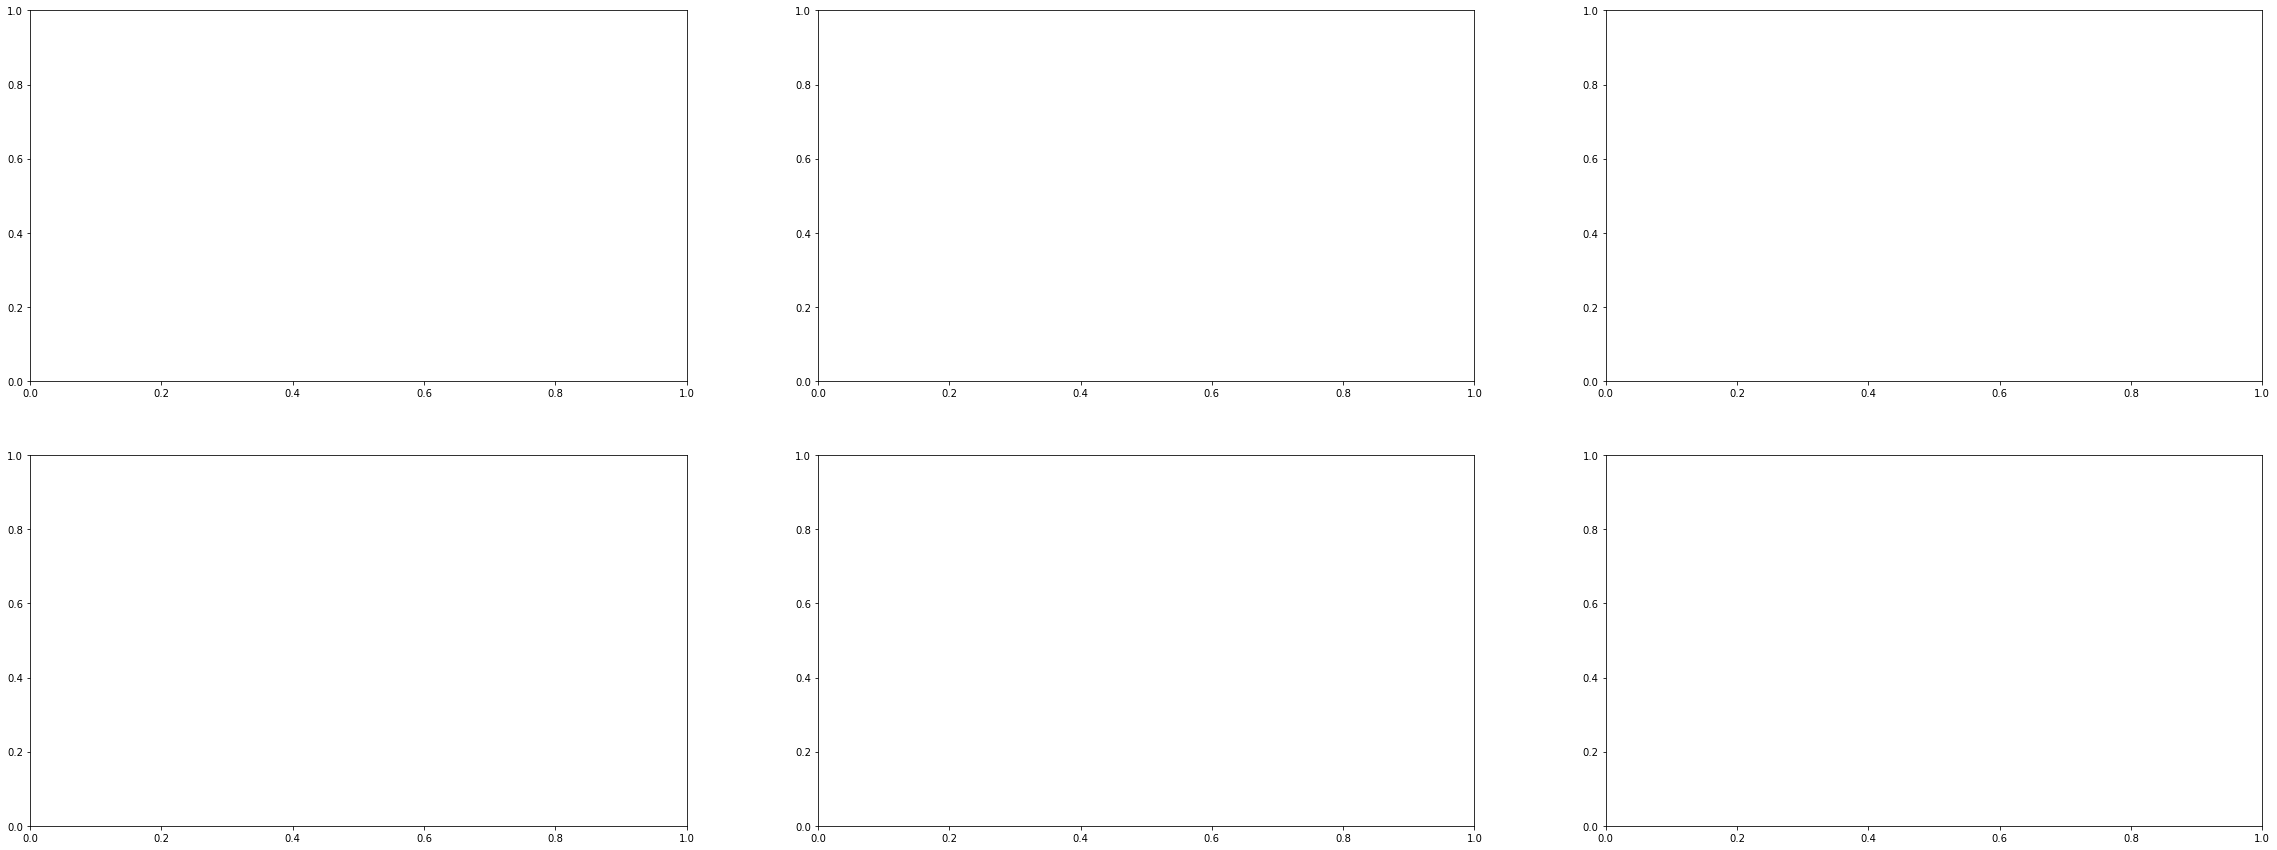

In [3]:
sim = DynamicSimulation()
sim.run()

In [69]:
a = np.array([1, 0])
a.shape=(1,2)
b = np.array([[1, 2], [-3, -1], [17.76,1.776]]).T
b_norm = np.sum(np.abs(b)**2,axis=0)**(1./2)
print(b_norm)
print(a.shape, b.shape)
c = np.arctan2(a[:,0]*b[1,:]-a[:,1]*b[0,:],a[:,0]*b[0,:]+a[:,1]*b[1,:])
print(np.rad2deg(c))

[ 2.23606798  3.16227766 17.8485791 ]
(1, 2) (2, 3)
[  63.43494882 -161.56505118    5.71059314]


### Simple example

a1 error:0.12405672913285892
a2 error:0.005081171692870597
a3 error:2.7236179941667396e-06
a1=3.124056729132859 a2=0.024918828307129402 a3=-0.003997276382005833


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)


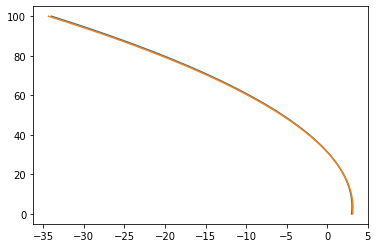

In [3]:
a1, a2, a3 = 3, 0.03, -0.004
dR, dAz = 0.4, 0.05 # [m,rad]
model = ExtendedObjectTrack(gamma=0.99)

for t in range(50):
    [_,_,x_meas,y_meas,meas_cov] = generatePolynomNoisyPoints(N=20,a1=a1,a2=a2,a3=a3,dR=dR,dAz=dAz)
    model.predict()
    for x,y,cov in zip(x_meas,y_meas,meas_cov):
        Hse = np.array([1 if x < model.getStateVector()[3] else 0, 1 if x > model.getStateVector()[4] else 0])
        H = np.array([[0, 0, 0, Hse[0], Hse[1]],[1, x, x**2, 0, 0]])
        R = np.diag([cov[0,0], cov[1,1]])
        z = np.array([x, y]).T
        model.update(z=z,current_frame_idx=t,H=H,R=R)
    model.save() # save the filter's state
states = model.getHistory()
print("a1 error:{}".format(np.abs(a1-states[-1,0,0])))
print("a2 error:{}".format(np.abs(a2-states[-1,1,0])))
print("a3 error:{}".format(np.abs(a3-states[-1,2,0])))
plt.figure()
x, y = createPolynom(a1=a1,a2=a2,a3=a3)
plt.plot(y,x,label='true')
print("a1={} a2={} a3={}".format(states[-1,0,0],states[-1,1,0],states[-1,2,0]))
x_est, y_est = createPolynom(a1=states[-1,0,0],a2=states[-1,1,0],a3=states[-1,2,0])
plt.plot(y_est,x_est,label='estimated')

### Tracker Example

t 0
Number of point tracks before run() 0
Number of extended tracks before run() 0
len(unique_polynoms) 0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


t 1
Number of point tracks before run() 85
Number of extended tracks before run() 1
Updating extended object track =  0
P after update [[ 5.57606933e-02 -1.02138660e-02  3.17076802e-04  0.00000000e+00
   0.00000000e+00]
 [-1.02138660e-02  5.39467237e-03 -2.02368910e-04  0.00000000e+00
   0.00000000e+00]
 [ 3.17076802e-04 -2.02368910e-04  8.19539977e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.30306728e-01
   4.81525615e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.81525615e-03
   5.29677496e+01]]
Updating extended object track =  0
P after update [[ 5.34854652e-02 -8.28067531e-03  2.18707607e-04  0.00000000e+00
   0.00000000e+00]
 [-8.28067531e-03  3.75210016e-03 -1.18787655e-04  0.00000000e+00
   0.00000000e+00]
 [ 2.18707607e-04 -1.18787655e-04  3.94242015e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.30306309e-01
   2.08966486e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+0

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Updating extended object track =  0
P after update [[ 5.09691509e-02 -6.52179384e-03  1.50629414e-04  0.00000000e+00
   0.00000000e+00]
 [-6.52179384e-03  2.52265756e-03 -7.12016004e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.50629414e-04 -7.12016004e-05  2.10058333e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.12585508e+00
   1.48292181e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.48292181e-02
   2.23569783e+00]]
Updating extended object track =  0
P after update [[ 4.90836822e-02 -7.04153992e-03  1.68289526e-04  0.00000000e+00
   0.00000000e+00]
 [-7.04153992e-03  2.37938497e-03 -6.63334347e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.68289526e-04 -6.63334347e-05  1.93517112e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.12585508e+00
   1.48292181e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.48292181e-02
   2.23569783e+00]]
Updating extended object track =  0
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


len(unique_polynoms) 1
t 3
Number of point tracks before run() 241
Number of extended tracks before run() 1


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 4.49560316e-02 -6.69840939e-03  1.62122613e-04  0.00000000e+00
   0.00000000e+00]
 [-6.69840939e-03  1.62015869e-03 -4.37345966e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.62122613e-04 -4.37345966e-05  1.25837652e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.92434680e+00
   1.58534350e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.58534350e-01
   7.14979584e+00]]
Updating extended object track =  0
P after update [[ 4.40837370e-02 -6.26051310e-03  1.49870404e-04  0.00000000e+00
   0.00000000e+00]
 [-6.26051310e-03  1.40033253e-03 -3.75839257e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.49870404e-04 -3.75839257e-05  1.08628256e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.92434680e+00
   1.58534350e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.58534350e-01
   7.14979584e+00]]
Updating extended object track =  0
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 4
Number of point tracks before run() 296
Number of extended tracks before run() 1


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 2.44085458e-02 -3.52562002e-03  8.68567582e-05  0.00000000e+00
   0.00000000e+00]
 [-3.52562002e-03  9.63986857e-04 -2.75235720e-05  0.00000000e+00
   0.00000000e+00]
 [ 8.68567582e-05 -2.75235720e-05  8.54331101e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.29464570e-01
   4.33589692e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.33589692e-03
   1.18606842e+01]]
Updating extended object track =  0
P after update [[ 2.37164469e-02 -3.23459860e-03  7.47432816e-05  0.00000000e+00
   0.00000000e+00]
 [-3.23459860e-03  8.41614938e-04 -2.24299629e-05  0.00000000e+00
   0.00000000e+00]
 [ 7.47432816e-05 -2.24299629e-05  6.42314695e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.29463340e-01
   9.71228494e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.71228494e-04
   2.65675930e+00]]
len(unique_polynoms) 1
t 5
Number of point tra

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Updating extended object track =  0
P after update [[ 2.32517488e-02 -3.01143837e-03  6.88491515e-05  0.00000000e+00
   0.00000000e+00]
 [-3.01143837e-03  7.34447539e-04 -1.95994469e-05  0.00000000e+00
   0.00000000e+00]
 [ 6.88491515e-05 -1.95994469e-05  5.67554827e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.12543737e+00
   5.55431201e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.55431201e-02
   7.55164149e+00]]
Updating extended object track =  0
P after update [[ 2.27811380e-02 -2.82849440e-03  6.17009716e-05  0.00000000e+00
   0.00000000e+00]
 [-2.82849440e-03  6.63330400e-04 -1.68206830e-05  0.00000000e+00
   0.00000000e+00]
 [ 6.17009716e-05 -1.68206830e-05  4.58980030e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.12517034e+00
   1.92380570e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.92380570e-02
   2.61560585e+00]]


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


len(unique_polynoms) 1
t 6
Number of point tracks before run() 293
Number of extended tracks before run() 1


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 2.27389696e-02 -2.85476804e-03  6.24838994e-05  0.00000000e+00
   0.00000000e+00]
 [-2.85476804e-03  6.46960235e-04 -1.63328686e-05  0.00000000e+00
   0.00000000e+00]
 [ 6.24838994e-05 -1.63328686e-05  4.44443654e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.92401397e+00
   1.70203138e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.70203138e-01
   7.51483205e+00]]
len(unique_polynoms) 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 7
Number of point tracks before run() 300
Number of extended tracks before run() 1


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


len(unique_polynoms) 0
t 8
Number of point tracks before run() 306
Number of extended tracks before run() 2


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  1
P after update [[ 5.44528473e+00 -2.89629881e-01  3.53654786e-03  0.00000000e+00
   0.00000000e+00]
 [-2.89629881e-01  1.58154763e-02 -1.96550526e-04  0.00000000e+00
   0.00000000e+00]
 [ 3.53654786e-03 -1.96550526e-04  2.47955580e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.29032936e+00
   4.76818540e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.76818540e-02
   5.29693336e+01]]
Updating extended object track =  1
P after update [[ 3.64447545e+00 -2.05369371e-01  2.59402646e-03  0.00000000e+00
   0.00000000e+00]
 [-2.05369371e-01  1.18728969e-02 -1.52449613e-04  0.00000000e+00
   0.00000000e+00]
 [ 2.59402646e-03 -1.52449613e-04  1.98625170e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.24443186e-01
   2.30752007e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.30752007e-02
   5.29684243e+01]]
Updating extended object track =  0
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 9
Number of point tracks before run() 299
Number of extended tracks before run() 2


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 2.25049699e-02 -2.73540214e-03  5.91063383e-05  0.00000000e+00
   0.00000000e+00]
 [-2.73540214e-03  5.86059752e-04 -1.46028587e-05  0.00000000e+00
   0.00000000e+00]
 [ 5.91063383e-05 -1.46028587e-05  3.90953832e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.31702295e+01
   2.32848349e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.32848349e-01
   2.94670442e+00]]
len(unique_polynoms) 1
t 10
Number of point tracks before run() 304
Number of extended tracks before run() 2


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 2.24943845e-02 -2.71911274e-03  5.86592187e-05  0.00000000e+00
   0.00000000e+00]
 [-2.71911274e-03  5.60992643e-04 -1.39148044e-05  0.00000000e+00
   0.00000000e+00]
 [ 5.86592187e-05 -1.39148044e-05  3.72067783e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.72629948e+01
   7.35612599e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.35612599e-01
   7.84841067e+00]]
Updating extended object track =  1
P after update [[ 3.07805059e+00 -1.71246181e-01  2.16603572e-03  0.00000000e+00
   0.00000000e+00]
 [-1.71246181e-01  9.81721021e-03 -1.26666124e-04  0.00000000e+00
   0.00000000e+00]
 [ 2.16603572e-03 -1.26666124e-04  1.66286182e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.04635780e+01
   2.23582448e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.23582448e+00
   5.87037910e+01]]
Updating extended object track =  1
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


len(unique_polynoms) 0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 12
Number of point tracks before run() 300
Number of extended tracks before run() 2


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 2.23504443e-02 -2.74218783e-03  5.94402268e-05  0.00000000e+00
   0.00000000e+00]
 [-2.74218783e-03  5.57293469e-04 -1.37896009e-05  0.00000000e+00
   0.00000000e+00]
 [ 5.94402268e-05 -1.37896009e-05  3.67830097e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.50389408e+01
   2.19861482e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.19861482e+00
   1.71464601e+01]]
Updating extended object track =  0
P after update [[ 2.17975375e-02 -2.73375291e-03  5.96851599e-05  0.00000000e+00
   0.00000000e+00]
 [-2.73375291e-03  5.57164789e-04 -1.37933375e-05  0.00000000e+00
   0.00000000e+00]
 [ 5.96851599e-05 -1.37933375e-05  3.67721594e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.33305490e-02
   5.22880473e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.22880473e-03
   1.70088301e+01]]
Updating extended object track =  0
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 13
Number of point tracks before run() 301
Number of extended tracks before run() 3


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  2
P after update [[ 2.84363606e-01 -4.32879055e-02  1.33853000e-03  0.00000000e+00
   0.00000000e+00]
 [-4.32879055e-02  7.83799950e-03 -2.61225276e-04  0.00000000e+00
   0.00000000e+00]
 [ 1.33853000e-03 -2.61225276e-04  9.17191964e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.30400000e+01
   1.96000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.96000000e+00
   5.30400000e+01]]
Updating extended object track =  1
P after update [[ 2.66923905e+00 -1.45198048e-01  1.82814061e-03  0.00000000e+00
   0.00000000e+00]
 [-1.45198048e-01  8.11533732e-03 -1.04250223e-04  0.00000000e+00
   0.00000000e+00]
 [ 1.82814061e-03 -1.04250223e-04  1.36482688e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.41574640e+01
   6.32211839e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.32211839e+00
   6.68373171e+01]]
Updating extended object track =  2
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 14
Number of point tracks before run() 293
Number of extended tracks before run() 3


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  2
P after update [[ 9.74867642e-03 -1.25537158e-03  3.30272217e-05  0.00000000e+00
   0.00000000e+00]
 [-1.25537158e-03  7.62533853e-04 -2.76552218e-05  0.00000000e+00
   0.00000000e+00]
 [ 3.30272217e-05 -2.76552218e-05  1.08978918e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.59543128e-01
   3.12167814e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.12167814e-03
   5.96065096e+00]]
Updating extended object track =  0
P after update [[ 2.15248935e-02 -2.75182821e-03  6.04376170e-05  0.00000000e+00
   0.00000000e+00]
 [-2.75182821e-03  5.46618105e-04 -1.34797411e-05  0.00000000e+00
   0.00000000e+00]
 [ 6.04376170e-05 -1.34797411e-05  3.58205797e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.03626582e-01
   8.83387878e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.83387878e-03
   2.54347509e+01]]
Updating extended object track =  1
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  1
P after update [[ 2.54822197e+00 -1.40729286e-01  1.78830704e-03  0.00000000e+00
   0.00000000e+00]
 [-1.40729286e-01  7.93788807e-03 -1.02532502e-04  0.00000000e+00
   0.00000000e+00]
 [ 1.78830704e-03 -1.02532502e-04  1.34681623e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.60695725e+00
   4.65566641e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.65566641e-01
   6.94088348e+01]]
Updating extended object track =  1
P after update [[ 2.21489295e+00 -1.19996189e-01  1.48692860e-03  0.00000000e+00
   0.00000000e+00]
 [-1.19996189e-01  6.64828747e-03 -8.37867340e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.48692860e-03 -8.37867340e-05  1.07432580e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.60418254e+00
   5.18999320e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.18999320e-02
   7.73748264e+00]]
Updating extended object track =  0
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 16
Number of point tracks before run() 294
Number of extended tracks before run() 3


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  2
P after update [[ 9.52970576e-03 -1.30173211e-03  3.53866712e-05  0.00000000e+00
   0.00000000e+00]
 [-1.30173211e-03  6.87873835e-04 -2.48922418e-05  0.00000000e+00
   0.00000000e+00]
 [ 3.53866712e-05 -2.48922418e-05  9.77331514e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.96067463e+00
   4.29393606e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.29393606e-01
   1.53069756e+01]]
Updating extended object track =  1
P after update [[ 1.98161533e+00 -1.05685422e-01  1.28271939e-03  0.00000000e+00
   0.00000000e+00]
 [-1.05685422e-01  5.77037193e-03 -7.12592129e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.28271939e-03 -7.12592129e-05  8.95562834e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.54329029e+00
   9.97396871e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.97396871e-02
   5.32335012e+00]]
Updating extended object track =  2
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 17
Number of point tracks before run() 313
Number of extended tracks before run() 3


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  1
P after update [[ 1.69245551e+00 -8.82033939e-02  1.03814487e-03  0.00000000e+00
   0.00000000e+00]
 [-8.82033939e-02  4.71339764e-03 -5.64712116e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.03814487e-03 -5.64712116e-05  6.88648954e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.12837614e+01
   1.38605691e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.38605691e-01
   4.46656941e+00]]
Updating extended object track =  0
P after update [[ 1.67044673e-02 -2.16924735e-03  4.81545076e-05  0.00000000e+00
   0.00000000e+00]
 [-2.16924735e-03  4.58754548e-04 -1.15412219e-05  0.00000000e+00
   0.00000000e+00]
 [ 4.81545076e-05 -1.15412219e-05  3.15096688e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.92702693e-02
   1.18106793e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.18106793e-02
   3.67525156e+01]]
Updating extended object track =  2
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 18
Number of point tracks before run() 309
Number of extended tracks before run() 3


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  1
P after update [[ 1.64242513e+00 -8.63383661e-02  1.02118496e-03  0.00000000e+00
   0.00000000e+00]
 [-8.63383661e-02  4.64387330e-03 -5.58389816e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.02118496e-03 -5.58389816e-05  6.82899676e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.63456988e+00
   4.55866729e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.55866729e-02
   9.28858788e+00]]
Updating extended object track =  0
P after update [[ 1.67027442e-02 -2.16502378e-03  4.80362625e-05  0.00000000e+00
   0.00000000e+00]
 [-2.16502378e-03  4.48401729e-04 -1.12513798e-05  0.00000000e+00
   0.00000000e+00]
 [ 4.80362625e-05 -1.12513798e-05  3.06982141e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.10089915e+00
   7.33446704e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.33446704e-01
   4.02976147e+01]]
Updating extended object track =  2
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 19
Number of point tracks before run() 302
Number of extended tracks before run() 4


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  2
P after update [[ 4.95907957e-03 -6.80545039e-04  1.84420060e-05  0.00000000e+00
   0.00000000e+00]
 [-6.80545039e-04  4.66739972e-04 -1.71154338e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.84420060e-05 -1.71154338e-05  6.81640559e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.15725200e+00
   2.36233192e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.36233192e-01
   1.61498397e+01]]
Updating extended object track =  3
P after update [[ 1.00044996e-01 -1.52000513e-02  4.34135549e-04  0.00000000e+00
   0.00000000e+00]
 [-1.52000513e-02  3.35505980e-03 -1.07957242e-04  0.00000000e+00
   0.00000000e+00]
 [ 4.34135549e-04 -1.07957242e-04  3.72710850e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.29701529e+01
   6.98527480e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.98527480e-02
   1.89030090e+00]]
Updating extended object track =  1
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 20
Number of point tracks before run() 297
Number of extended tracks before run() 4
Updating extended object track =  2
P after update [[ 4.91084690e-03 -6.12299446e-04  1.51858387e-05  0.00000000e+00
   0.00000000e+00]
 [-6.12299446e-04  3.70177618e-04 -1.25082032e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.51858387e-05 -1.25082032e-05  4.61818102e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.95112802e+00
   8.37236503e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.37236503e-02
   2.66547850e+00]]
Updating extended object track =  3
P after update [[ 9.07743109e-03 -1.37389861e-03  3.91795683e-05  0.00000000e+00
   0.00000000e+00]
 [-1.37389861e-03  1.25362400e-03 -4.79279147e-05  0.00000000e+00
   0.00000000e+00]
 [ 3.91795683e-05 -4.79279147e-05  2.01231898e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.59543151e-01
   3.26184259e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


len(unique_polynoms) 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 21
Number of point tracks before run() 304
Number of extended tracks before run() 4


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 6.21111234e-03 -8.05694865e-04  1.77824616e-05  0.00000000e+00
   0.00000000e+00]
 [-8.05694865e-04  2.56548585e-04 -6.78412705e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.77824616e-05 -6.78412705e-06  1.96436136e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.58661364e-01
   9.05898459e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.05898459e-03
   1.73327902e+01]]
Updating extended object track =  1
P after update [[ 1.21848881e+00 -6.15969113e-02  7.03830824e-04  0.00000000e+00
   0.00000000e+00]
 [-6.15969113e-02  3.19584043e-03 -3.72078520e-05  0.00000000e+00
   0.00000000e+00]
 [ 7.03830824e-04 -3.72078520e-05  4.41477658e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.58754176e+01
   5.23296084e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.23296084e-01
   1.06921660e+01]]
Updating extended object track =  2
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 22
Number of point tracks before run() 297
Number of extended tracks before run() 4


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  2
P after update [[ 4.88153699e-03 -5.74294864e-04  1.36842752e-05  0.00000000e+00
   0.00000000e+00]
 [-5.74294864e-04  3.04464803e-04 -9.90725533e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.36842752e-05 -9.90725533e-06  3.50415267e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.89799958e+01
   4.24105727e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.24105727e-01
   7.18895348e+00]]
Updating extended object track =  3
P after update [[ 7.79716801e-03 -1.33975311e-03  4.07816151e-05  0.00000000e+00
   0.00000000e+00]
 [-1.33975311e-03  9.48363589e-04 -3.70090591e-05  0.00000000e+00
   0.00000000e+00]
 [ 4.07816151e-05 -3.70090591e-05  1.61216782e-06  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.96199970e+00
   4.61741625e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.61741625e-01
   1.60966660e+01]]
Updating extended object track =  1
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 23
Number of point tracks before run() 298
Number of extended tracks before run() 4


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  1
P after update [[ 1.08311304e+00 -5.43753470e-02  6.16614260e-04  0.00000000e+00
   0.00000000e+00]
 [-5.43753470e-02  2.80207265e-03 -3.23827964e-05  0.00000000e+00
   0.00000000e+00]
 [ 6.16614260e-04 -3.23827964e-05  3.81530799e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.14222094e+01
   3.87841683e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.87841683e-01
   1.14319158e+01]]
Updating extended object track =  3
P after update [[ 7.63412008e-03 -1.13028174e-03  2.92081029e-05  0.00000000e+00
   0.00000000e+00]
 [-1.13028174e-03  6.77819209e-04 -2.19799449e-05  0.00000000e+00
   0.00000000e+00]
 [ 2.92081029e-05 -2.19799449e-05  7.72692920e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.45509187e+01
   8.56952885e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.56952885e-02
   2.04709356e+00]]
Updating extended object track =  3
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 24
Number of point tracks before run() 299
Number of extended tracks before run() 4


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  3
P after update [[ 7.55878827e-03 -1.18435649e-03  3.11348597e-05  0.00000000e+00
   0.00000000e+00]
 [-1.18435649e-03  6.38817993e-04 -2.05906458e-05  0.00000000e+00
   0.00000000e+00]
 [ 3.11348597e-05 -2.05906458e-05  7.23202658e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.89788804e+01
   4.07657073e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.07657073e-01
   6.97520827e+00]]
Updating extended object track =  1
P after update [[ 9.70779502e-01 -4.84158862e-02  5.51310461e-04  0.00000000e+00
   0.00000000e+00]
 [-4.84158862e-02  2.48568189e-03 -2.89121736e-05  0.00000000e+00
   0.00000000e+00]
 [ 5.51310461e-04 -2.89121736e-05  3.43403728e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.59896661e+01
   8.20579142e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.20579142e-01
   1.59989842e+01]]
Updating extended object track =  3
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  2
P after update [[ 4.77435972e-03 -5.80226472e-04  1.40375868e-05  0.00000000e+00
   0.00000000e+00]
 [-5.80226472e-04  2.80006567e-04 -9.09302225e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.40375868e-05 -9.09302225e-06  3.23069408e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.12615263e-02
   5.39115166e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.39115166e-03
   2.07416427e+01]]
Updating extended object track =  1
P after update [[ 8.44254790e-01 -4.13976430e-02  4.63671373e-04  0.00000000e+00
   0.00000000e+00]
 [-4.13976430e-02  2.09606193e-03 -2.40375735e-05  0.00000000e+00
   0.00000000e+00]
 [ 4.63671373e-04 -2.40375735e-05  2.82149558e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.03356596e+01
   5.59350658e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.59350658e-01
   8.06349039e+00]]
len(unique_polynoms) 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 26
Number of point tracks before run() 299
Number of extended tracks before run() 4


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  2
P after update [[ 4.72713577e-03 -5.88078314e-04  1.43711989e-05  0.00000000e+00
   0.00000000e+00]
 [-5.88078314e-04  2.78701056e-04 -9.03755316e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.43711989e-05 -9.03755316e-06  3.20712616e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.07694756e+00
   4.13112740e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.13112740e-01
   2.49205134e+01]]
Updating extended object track =  2
P after update [[ 4.71604409e-03 -5.95529269e-04  1.46405835e-05  0.00000000e+00
   0.00000000e+00]
 [-5.95529269e-04  2.73695797e-04 -8.85659122e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.46405835e-05 -8.85659122e-06  3.14170052e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.07694756e+00
   4.13112740e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.13112740e-01
   2.49205134e+01]]
Updating extended object track =  2
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 27
Number of point tracks before run() 309
Number of extended tracks before run() 4


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  3
P after update [[ 7.33231887e-03 -1.14962855e-03  3.04567065e-05  0.00000000e+00
   0.00000000e+00]
 [-1.14962855e-03  5.49057812e-04 -1.77885605e-05  0.00000000e+00
   0.00000000e+00]
 [ 3.04567065e-05 -1.77885605e-05  6.34909012e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.12615083e-02
   5.33189510e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.33189510e-03
   2.05539678e+01]]
Updating extended object track =  2
P after update [[ 4.68935841e-03 -6.02884824e-04  1.49782077e-05  0.00000000e+00
   0.00000000e+00]
 [-6.02884824e-04  2.71116667e-04 -8.77280199e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.49782077e-05 -8.77280199e-06  3.09742613e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.90206266e+00
   9.84868957e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.84868957e-01
   2.89518859e+01]]
Updating extended object track =  0
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 6.10732023e-03 -7.90862016e-04  1.74261519e-05  0.00000000e+00
   0.00000000e+00]
 [-7.90862016e-04  2.35101305e-04 -6.14997011e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.74261519e-05 -6.14997011e-06  1.75287597e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.14344795e+01
   3.01631275e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.01631275e+00
   2.60225530e+01]]
Updating extended object track =  2
P after update [[ 4.67286948e-03 -5.85211159e-04  1.42961068e-05  0.00000000e+00
   0.00000000e+00]
 [-5.85211159e-04  2.47833355e-04 -7.88180769e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.42961068e-05 -7.88180769e-06  2.72605169e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.44852421e+01
   3.30901971e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.30901971e-01
   7.53168506e+00]]
len(unique_polynoms) 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 29
Number of point tracks before run() 305
Number of extended tracks before run() 4


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 3.77142691e-03 -4.85627608e-04  1.06803930e-05  0.00000000e+00
   0.00000000e+00]
 [-4.85627608e-04  1.95215903e-04 -5.26849248e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.06803930e-05 -5.26849248e-06  1.55806715e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.59278433e-01
   1.81484618e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.81484618e-02
   2.96664131e+01]]
Updating extended object track =  1
P after update [[ 7.58238106e-01 -3.65392907e-02  4.03640515e-04  0.00000000e+00
   0.00000000e+00]
 [-3.65392907e-02  1.82117115e-03 -2.06363931e-05  0.00000000e+00
   0.00000000e+00]
 [ 4.03640515e-04 -2.06363931e-05  2.39853905e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.60670986e+01
   1.19073744e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.19073744e+00
   8.64999837e+00]]
Updating extended object track =  0
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 3.74705920e-03 -4.92976011e-04  1.09230334e-05  0.00000000e+00
   0.00000000e+00]
 [-4.92976011e-04  1.92350025e-04 -5.17218390e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.09230334e-05 -5.17218390e-06  1.51593417e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.15563458e+00
   5.04492408e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.04492408e-02
   2.80665824e+00]]
Updating extended object track =  2
P after update [[ 4.67029608e-03 -5.83971125e-04  1.43031249e-05  0.00000000e+00
   0.00000000e+00]
 [-5.83971125e-04  2.47235825e-04 -7.88518946e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.43031249e-05 -7.88518946e-06  2.72586030e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.32123570e+01
   1.33120767e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.33120767e+00
   1.68039588e+01]]
Updating extended object track =  2
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 31
Number of point tracks before run() 301
Number of extended tracks before run() 5


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 3.74558772e-03 -4.95136615e-04  1.09857091e-05  0.00000000e+00
   0.00000000e+00]
 [-4.95136615e-04  1.89177566e-04 -5.08015582e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.09857091e-05 -5.08015582e-06  1.48923826e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.95457173e+00
   2.04532570e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.04532570e-01
   7.69955443e+00]]
Updating extended object track =  3
P after update [[ 7.02081541e-03 -1.09919478e-03  2.92355580e-05  0.00000000e+00
   0.00000000e+00]
 [-1.09919478e-03  4.99131249e-04 -1.62460781e-05  0.00000000e+00
   0.00000000e+00]
 [ 2.92355580e-05 -1.62460781e-05  5.86818099e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.93114579e+00
   1.28780933e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.28780933e+00
   3.62830881e+01]]
Updating extended object track =  2
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 32
Number of point tracks before run() 300
Number of extended tracks before run() 5


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  1
P after update [[ 7.37921269e-01 -3.54839783e-02  3.91912867e-04  0.00000000e+00
   0.00000000e+00]
 [-3.54839783e-02  1.76487680e-03 -1.99802937e-05  0.00000000e+00
   0.00000000e+00]
 [ 3.91912867e-04 -1.99802937e-05  2.31593917e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.66150916e+01
   4.06264207e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.06264207e+00
   2.23581961e+01]]
Updating extended object track =  1
P after update [[ 7.21163209e-01 -3.45127542e-02  3.78865348e-04  0.00000000e+00
   0.00000000e+00]
 [-3.45127542e-02  1.70858888e-03 -1.92241163e-05  0.00000000e+00
   0.00000000e+00]
 [ 3.78865348e-04 -1.92241163e-05  2.21435358e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.66150916e+01
   4.06264207e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.06264207e+00
   2.23581961e+01]]
Updating extended object track =  1
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 33
Number of point tracks before run() 303
Number of extended tracks before run() 5


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  4
P after update [[ 4.77560890e-01 -3.02728500e-02  4.31074286e-04  0.00000000e+00
   0.00000000e+00]
 [-3.02728500e-02  2.12078898e-03 -3.21623979e-05  0.00000000e+00
   0.00000000e+00]
 [ 4.31074286e-04 -3.21623979e-05  5.13557319e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.93552346e-01
   1.13039766e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.13039766e-02
   1.20185721e+01]]
Updating extended object track =  3
P after update [[ 6.69063709e-03 -1.05338070e-03  2.83087859e-05  0.00000000e+00
   0.00000000e+00]
 [-1.05338070e-03  4.51325800e-04 -1.48202246e-05  0.00000000e+00
   0.00000000e+00]
 [ 2.83087859e-05 -1.48202246e-05  5.43481960e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.94278035e+00
   1.57037619e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.57037619e+00
   4.31464836e+01]]
len(unique_polynoms) 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 34
Number of point tracks before run() 294
Number of extended tracks before run() 5


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  1
P after update [[ 7.12105387e-01 -3.39949151e-02  3.73213146e-04  0.00000000e+00
   0.00000000e+00]
 [-3.39949151e-02  1.67754273e-03 -1.88719345e-05  0.00000000e+00
   0.00000000e+00]
 [ 3.73213146e-04 -1.88719345e-05  2.17322980e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.89650729e+00
   3.56797400e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.56797400e-01
   3.00583883e+01]]
Updating extended object track =  2
P after update [[ 4.25964215e-03 -5.16350032e-04  1.22629653e-05  0.00000000e+00
   0.00000000e+00]
 [-5.16350032e-04  2.12409190e-04 -6.58197477e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.22629653e-05 -6.58197477e-06  2.21665728e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.89475223e+01
   2.18641354e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.18641354e-01
   3.15999571e+00]]
Updating extended object track =  4
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 35
Number of point tracks before run() 290
Number of extended tracks before run() 5


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 3.72252418e-03 -4.97745408e-04  1.10653715e-05  0.00000000e+00
   0.00000000e+00]
 [-4.97745408e-04  1.88309953e-04 -5.03149412e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.10653715e-05 -5.03149412e-06  1.45902601e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.72470052e+01
   2.83813181e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.83813181e-01
   2.87619557e+00]]
Updating extended object track =  4
P after update [[ 3.30440025e-01 -2.22370879e-02  3.28318171e-04  0.00000000e+00
   0.00000000e+00]
 [-2.22370879e-02  1.66227404e-03 -2.61198188e-05  0.00000000e+00
   0.00000000e+00]
 [ 3.28318171e-04 -2.61198188e-05  4.32353062e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.50104920e-01
   2.31625245e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.31625245e-02
   2.08571862e+01]]
Updating extended object track =  3
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  3
P after update [[ 6.60018264e-03 -9.85757563e-04  2.56625029e-05  0.00000000e+00
   0.00000000e+00]
 [-9.85757563e-04  3.99659507e-04 -1.26791278e-05  0.00000000e+00
   0.00000000e+00]
 [ 2.56625029e-05 -1.26791278e-05  4.39510096e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.31370185e+01
   1.56776180e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.56776180e-01
   1.96680181e+00]]
Updating extended object track =  2
P after update [[ 4.25946176e-03 -5.17371886e-04  1.22964455e-05  0.00000000e+00
   0.00000000e+00]
 [-5.17371886e-04  2.06620617e-04 -6.39231687e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.22964455e-05 -6.39231687e-06  2.15451741e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.73164774e+01
   1.23081523e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.23081523e+00
   1.27666929e+01]]
Updating extended object track =  4
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 37
Number of point tracks before run() 297
Number of extended tracks before run() 5


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 3.69176823e-03 -4.88876395e-04  1.08612749e-05  0.00000000e+00
   0.00000000e+00]
 [-4.88876395e-04  1.78534907e-04 -4.77647236e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.08612749e-05 -4.77647236e-06  1.39216534e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.49825072e+01
   1.59297542e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.59297542e+00
   1.25223691e+01]]
Updating extended object track =  4
P after update [[ 1.34579846e-01 -8.89201359e-03  1.24950496e-04  0.00000000e+00
   0.00000000e+00]
 [-8.89201359e-03  6.88435902e-04 -1.05172433e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.24950496e-04 -1.05172433e-05  1.71732169e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.88448888e+00
   3.47033053e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.47033053e-01
   1.34090062e+01]]
Updating extended object track =  2
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Updating extended object track =  4
P after update [[ 1.20515498e-01 -8.05914454e-03  1.13539655e-04  0.00000000e+00
   0.00000000e+00]
 [-8.05914454e-03  6.30127148e-04 -9.58816220e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.13539655e-04 -9.58816220e-06  1.54496473e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.45120304e+01
   7.89981860e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.89981860e-01
   1.78955670e+01]]
Updating extended object track =  0
P after update [[ 3.69173443e-03 -4.88923039e-04  1.08675314e-05  0.00000000e+00
   0.00000000e+00]
 [-4.88923039e-04  1.78470542e-04 -4.76783878e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.08675314e-05 -4.76783878e-06  1.38058480e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.83641717e+01
   3.73934319e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.73934319e-01
   2.59802592e+00]]
Updating extended object track =  1
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


len(unique_polynoms) 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 39
Number of point tracks before run() 297
Number of extended tracks before run() 5


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  4
P after update [[ 6.18107200e-02 -4.25369872e-03  6.08518066e-05  0.00000000e+00
   0.00000000e+00]
 [-4.25369872e-03  3.83445049e-04 -6.17275450e-06  0.00000000e+00
   0.00000000e+00]
 [ 6.08518066e-05 -6.17275450e-06  1.07208851e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.96543549e-02
   6.58725981e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.58725981e-03
   2.21217210e+01]]
Updating extended object track =  3
P after update [[ 6.48591690e-03 -9.09313327e-04  2.23033526e-05  0.00000000e+00
   0.00000000e+00]
 [-9.09313327e-04  3.48518005e-04 -1.04318427e-05  0.00000000e+00
   0.00000000e+00]
 [ 2.23033526e-05 -1.04318427e-05  3.40758788e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.47811766e+01
   3.77091475e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.77091475e-01
   2.95525975e+00]]
Updating extended object track =  4
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 40
Number of point tracks before run() 307
Number of extended tracks before run() 5


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 3.68379961e-03 -4.81382242e-04  1.06671111e-05  0.00000000e+00
   0.00000000e+00]
 [-4.81382242e-04  1.71304203e-04 -4.57737085e-06  0.00000000e+00
   0.00000000e+00]
 [ 1.06671111e-05 -4.57737085e-06  1.32996198e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.52515320e+01
   2.08454107e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.08454107e+00
   1.22894521e+01]]
Updating extended object track =  3
P after update [[ 6.45114903e-03 -8.89283171e-04  2.18702941e-05  0.00000000e+00
   0.00000000e+00]
 [-8.89283171e-04  3.36978413e-04 -1.01823530e-05  0.00000000e+00
   0.00000000e+00]
 [ 2.18702941e-05 -1.01823530e-05  3.35364738e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.84198061e+01
   1.10194364e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.10194364e+00
   7.86692592e+00]]
Updating extended object track =  1
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 41
Number of point tracks before run() 314
Number of extended tracks before run() 5


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 2.70327803e-03 -3.54964527e-04  7.87811400e-06  0.00000000e+00
   0.00000000e+00]
 [-3.54964527e-04  1.55005286e-04 -4.21778810e-06  0.00000000e+00
   0.00000000e+00]
 [ 7.87811400e-06 -4.21778810e-06  1.25063170e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.59474400e-01
   1.02841290e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.02841290e-02
   1.67013806e+01]]
Updating extended object track =  4
P after update [[ 5.98374567e-02 -3.99059853e-03  5.51244443e-05  0.00000000e+00
   0.00000000e+00]
 [-3.99059853e-03  3.48266057e-04 -5.40474941e-06  0.00000000e+00
   0.00000000e+00]
 [ 5.51244443e-05 -5.40474941e-06  9.03934904e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.88887108e+00
   1.67274869e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.67274869e-01
   6.02016663e+00]]
Updating extended object track =  4
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  2
P after update [[ 4.04292674e-03 -4.36952801e-04  9.30422972e-06  0.00000000e+00
   0.00000000e+00]
 [-4.36952801e-04  1.40103006e-04 -3.86675393e-06  0.00000000e+00
   0.00000000e+00]
 [ 9.30422972e-06 -3.86675393e-06  1.16897270e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.44935335e+01
   5.62791012e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.62791012e-01
   1.30087612e+01]]
Updating extended object track =  4
P after update [[ 5.22056226e-02 -3.63838311e-03  5.13165755e-05  0.00000000e+00
   0.00000000e+00]
 [-3.63838311e-03  3.30784573e-04 -5.20427942e-06  0.00000000e+00
   0.00000000e+00]
 [ 5.13165755e-05 -5.20427942e-06  8.79947703e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.45062370e+01
   4.72534833e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.72534833e-01
   1.07922808e+01]]
Updating extended object track =  3
P after up

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 43
Number of point tracks before run() 295
Number of extended tracks before run() 5
Updating extended object track =  3
P after update [[ 6.21556012e-03 -8.72555285e-04  2.16218578e-05  0.00000000e+00
   0.00000000e+00]
 [-8.72555285e-04  3.22579950e-04 -9.72358706e-06  0.00000000e+00
   0.00000000e+00]
 [ 2.16218578e-05 -9.72358706e-06  3.18087862e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  8.99136209e-02
   7.51322260e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.51322260e-03
   2.13215942e+01]]
Updating extended object track =  4
P after update [[ 5.20382809e-02 -3.62389406e-03  5.12641392e-05  0.00000000e+00
   0.00000000e+00]
 [-3.62389406e-03  3.29530058e-04 -5.19973930e-06  0.00000000e+00
   0.00000000e+00]
 [ 5.12641392e-05 -5.19973930e-06  8.79783394e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.89546303e+01
   9.49862416e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


len(unique_polynoms) 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 44
Number of point tracks before run() 298
Number of extended tracks before run() 5
Updating extended object track =  4
P after update [[ 5.16815355e-02 -3.58785667e-03  5.09250875e-05  0.00000000e+00
   0.00000000e+00]
 [-3.58785667e-03  3.25726306e-04 -5.15755930e-06  0.00000000e+00
   0.00000000e+00]
 [ 5.09250875e-05 -5.15755930e-06  8.72711573e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.32474173e+01
   1.58576752e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.58576752e+00
   1.98246352e+01]]
Updating extended object track =  4
P after update [[ 5.11064719e-02 -3.51972838e-03  4.99807299e-05  0.00000000e+00
   0.00000000e+00]
 [-3.51972838e-03  3.17655087e-04 -5.04568042e-06  0.00000000e+00
   0.00000000e+00]
 [ 4.99807299e-05 -5.04568042e-06  8.57203529e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.32474173e+01
   1.58576752e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


len(unique_polynoms) 3
t 45
Number of point tracks before run() 285
Number of extended tracks before run() 5


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 2.56171866e-03 -3.31538756e-04  7.30100949e-06  0.00000000e+00
   0.00000000e+00]
 [-3.31538756e-04  1.38746740e-04 -3.74820407e-06  0.00000000e+00
   0.00000000e+00]
 [ 7.30100949e-06 -3.74820407e-06  1.10468176e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.89746117e+01
   2.47514730e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.47514730e-01
   3.57079280e+00]]
Updating extended object track =  4
P after update [[ 5.01119527e-02 -3.37245719e-03  4.70963365e-05  0.00000000e+00
   0.00000000e+00]
 [-3.37245719e-03  2.95356846e-04 -4.61621970e-06  0.00000000e+00
   0.00000000e+00]
 [ 4.70963365e-05 -4.61621970e-06  7.73436804e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.72649469e+01
   1.05125616e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.05125616e+00
   1.09761982e+01]]
Updating extended object track =  3
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  3
P after update [[ 4.53696303e-02 -3.11949388e-03  4.40198970e-05  0.00000000e+00
   0.00000000e+00]
 [-3.11949388e-03  2.81863365e-04 -4.45211733e-06  0.00000000e+00
   0.00000000e+00]
 [ 4.40198970e-05 -4.45211733e-06  7.53479324e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.32560889e-01
   7.46859514e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.46859514e-03
   1.54949409e+01]]
Updating extended object track =  1
P after update [[ 3.74291240e-03 -4.10606645e-04  8.80064611e-06  0.00000000e+00
   0.00000000e+00]
 [-4.10606645e-04  1.37789384e-04 -3.82253107e-06  0.00000000e+00
   0.00000000e+00]
 [ 8.80064611e-06 -3.82253107e-06  1.16051989e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.30086967e-01
   1.45520146e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.45520146e-02
   2.97760027e+01]]
Updating extended object track =  1
P after up

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Updating extended object track =  3
P after update [[ 4.53685167e-02 -3.12140910e-03  4.40583885e-05  0.00000000e+00
   0.00000000e+00]
 [-3.12140910e-03  2.78569408e-04 -4.38591639e-06  0.00000000e+00
   0.00000000e+00]
 [ 4.40583885e-05 -4.38591639e-06  7.40174457e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.13380222e+00
   3.13474862e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.13474862e-01
   1.98816870e+01]]
Updating extended object track =  3
P after update [[ 4.53634969e-02 -3.11991002e-03  4.40036546e-05  0.00000000e+00
   0.00000000e+00]
 [-3.11991002e-03  2.78121737e-04 -4.36957118e-06  0.00000000e+00
   0.00000000e+00]
 [ 4.40036546e-05 -4.36957118e-06  7.34206556e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.13380222e+00
   3.13474862e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.13474862e-01
   1.98816870e+01]]


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


len(unique_polynoms) 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tools.py:83: RuntimeWarning: divide by zero encountered in true_divide
  Az = np.arctan(y/x)
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t 48
Number of point tracks before run() 297
Number of extended tracks before run() 4


C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  3
P after update [[ 4.19129687e-02 -2.93814760e-03  4.18127029e-05  0.00000000e+00
   0.00000000e+00]
 [-2.93814760e-03  2.68547093e-04 -4.25415908e-06  0.00000000e+00
   0.00000000e+00]
 [ 4.18127029e-05 -4.25415908e-06  7.20294861e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.65056588e-01
   1.31287339e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.31287339e-02
   2.40468025e+01]]
Updating extended object track =  3
P after update [[ 4.14668182e-02 -2.87302856e-03  4.07632087e-05  0.00000000e+00
   0.00000000e+00]
 [-2.87302856e-03  2.59042476e-04 -4.10097745e-06  0.00000000e+00
   0.00000000e+00]
 [ 4.07632087e-05 -4.10097745e-06  6.95607269e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.65056588e-01
   1.31287339e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.31287339e-02
   2.40468025e+01]]
len(unique_polynoms) 1
t 49
Number of point tr

C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\gadli\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


Updating extended object track =  0
P after update [[ 2.55572388e-03 -3.26944274e-04  7.10763675e-06  0.00000000e+00
   0.00000000e+00]
 [-3.26944274e-04  1.35225470e-04 -3.60000071e-06  0.00000000e+00
   0.00000000e+00]
 [ 7.10763675e-06 -3.60000071e-06  1.04230587e-07  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.48429125e+01
   4.63735473e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.63735473e-01
   3.53177887e+00]]
Updating extended object track =  1
P after update [[ 3.70887790e-03 -3.88359754e-04  7.95863889e-06  0.00000000e+00
   0.00000000e+00]
 [-3.88359754e-04  1.23191384e-04 -3.26826024e-06  0.00000000e+00
   0.00000000e+00]
 [ 7.95863889e-06 -3.26826024e-06  9.49518822e-08  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.45283924e+01
   1.73004394e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.73004394e-01
   3.93115754e+00]]
Updating extended object track =  3
P after up

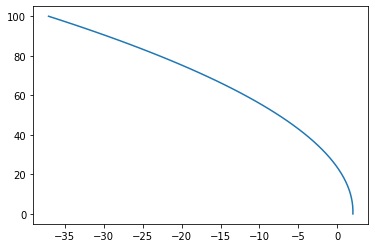

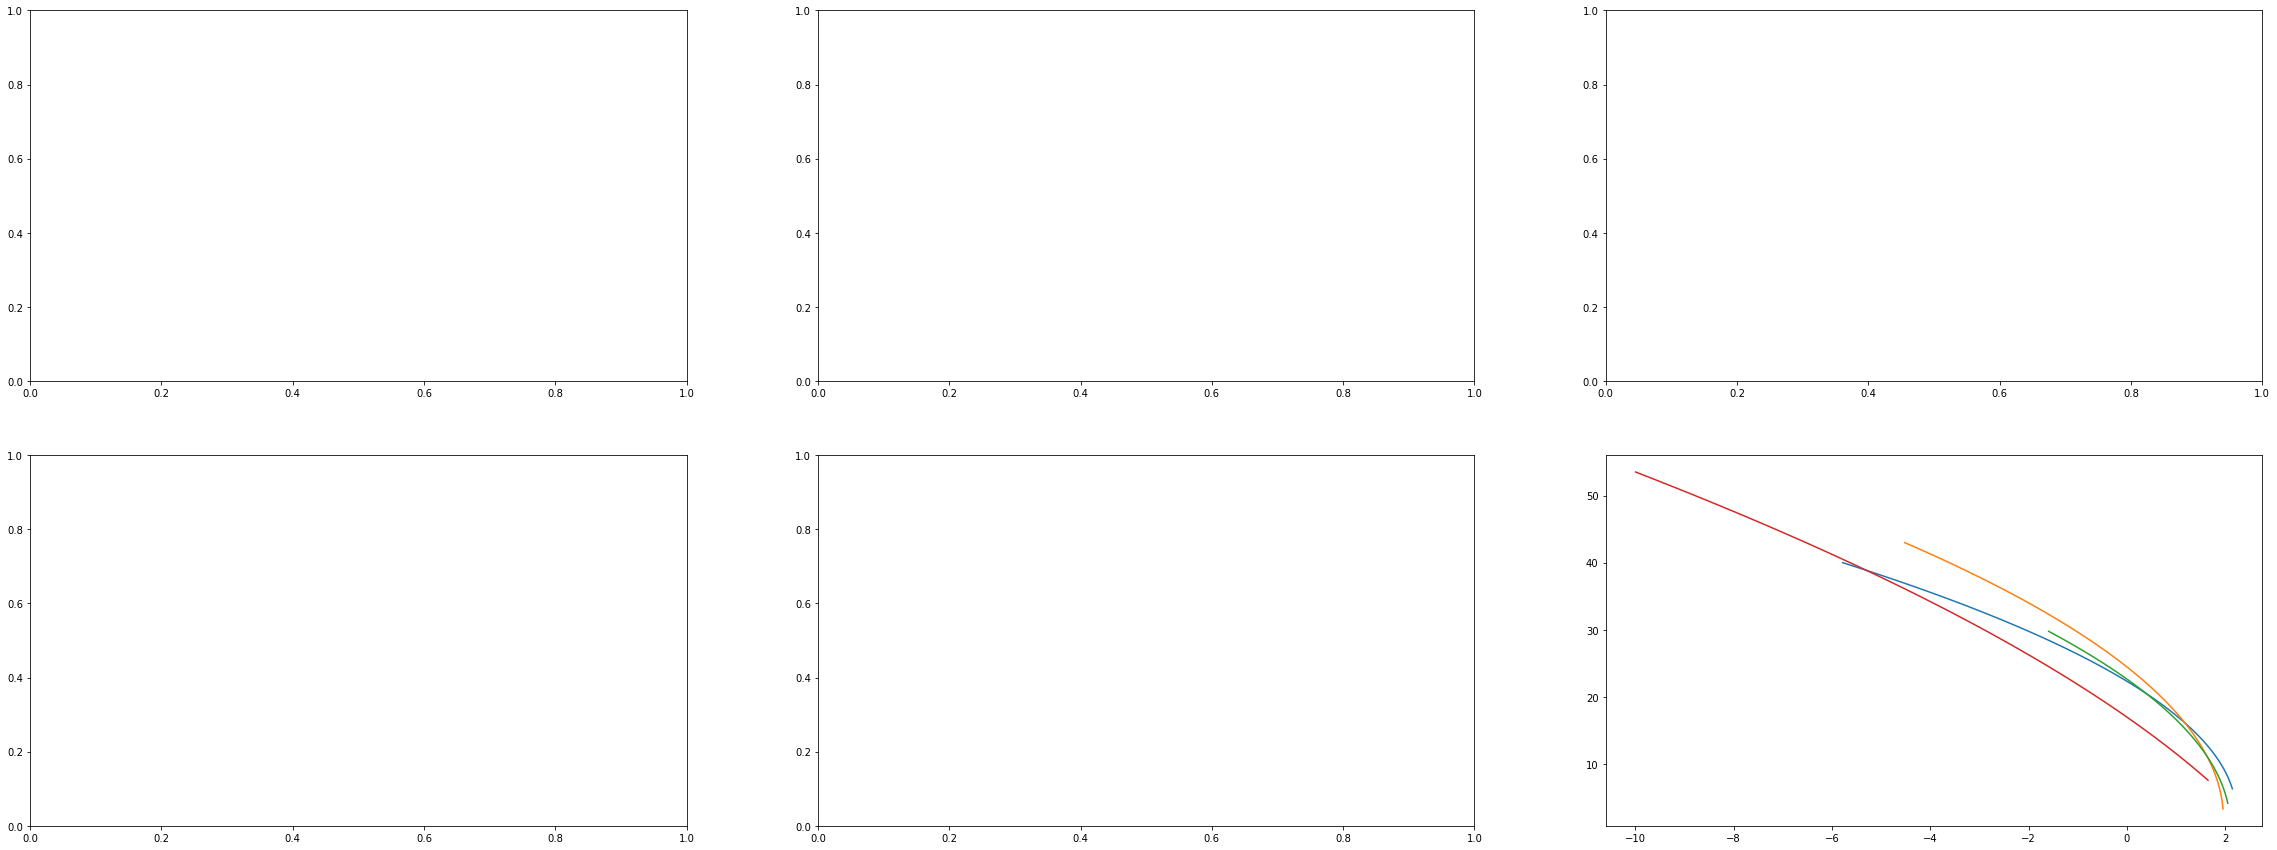

In [5]:
np.random.seed(0)

a1, a2, a3 = 2, 0.009, -0.004
dR, dAz = 0.4, 0.05 # [m,rad]
#prior = [a1+0.01,a2+0.0001,a3+0.0000001]
prior = [a1,a2,a3]
model = Tracker()

x, y = createPolynom(a1=a1,a2=a2,a3=a3)
plt.plot(y,x,label='true')

video = TrackVideo(x,y)

for t in range(50):
    [_,_,x_poly,y_poly,polynom_cov] = generatePolynomNoisyPoints(N=60,a1=a1,a2=a2,a3=a3,dR=dR,dAz=dAz)
    [x_noise,y_noise,noise_cov] = generateRandomNoisyPoints(N=40,xRange=[0,100],yRange=[-40,40],dR=dR,dAz=dAz)
    x_meas = np.concatenate([x_poly, x_noise])
    y_meas = np.concatenate([y_poly, y_noise])
    dz_meas = np.concatenate([polynom_cov, noise_cov])
    z = np.array([x_meas, y_meas]).T
    dz = np.array(dz_meas)
    print("t",t)
    measurements = {"polynom":np.array([x_poly, y_poly]).T,"dpolynom":polynom_cov,
                    "other":np.array([x_noise, y_noise]).T,"dother":noise_cov}
    points, polynoms = model.run(z,dz,prior)
    video.save(t, measurements, points, polynoms, model.getDebugInfo())
    
#for polynom in polynoms:
polynoms = model.getPolynoms()
for polynom in polynoms:
    x_plot = np.linspace(polynom["x_start"], polynom["x_end"], 100)
    y_plot = polynom["f"](x_plot)
    plt.plot(y_plot,x_plot,label='estimated')

model = Tracker()
model.innerProductPolynoms((1,2,3),(1,2.01,3.01),10,23)

In [13]:
A = np.zeros((3,3))
A[:,1] = 1
A[:,None] = 2
print(A)

[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]


track_0.png
track_1.png
track_2.png
track_3.png
track_4.png
track_5.png
track_6.png
track_7.png
track_8.png
track_9.png
track_10.png
track_11.png
track_12.png
track_13.png
track_14.png
track_15.png
track_16.png
track_17.png
track_18.png
track_19.png
track_20.png
track_21.png
track_22.png
track_23.png
track_24.png
track_25.png
track_26.png
track_27.png
track_28.png
track_29.png
track_30.png
track_31.png
track_32.png
track_33.png
track_34.png
track_35.png
track_36.png
track_37.png
track_38.png
track_39.png
track_40.png
track_41.png
track_42.png
track_43.png
track_44.png
track_45.png
track_46.png
track_47.png
track_48.png
track_49.png
track_50.png
track_51.png
track_52.png
track_53.png
track_54.png
track_55.png
track_56.png
track_57.png
track_58.png
track_59.png
track_60.png
track_61.png
track_62.png
track_63.png
track_64.png
track_65.png
track_66.png
track_67.png
track_68.png
track_69.png
track_70.png
track_71.png
track_72.png
track_73.png
track_74.png
track_75.png
track_76.png
track_77.

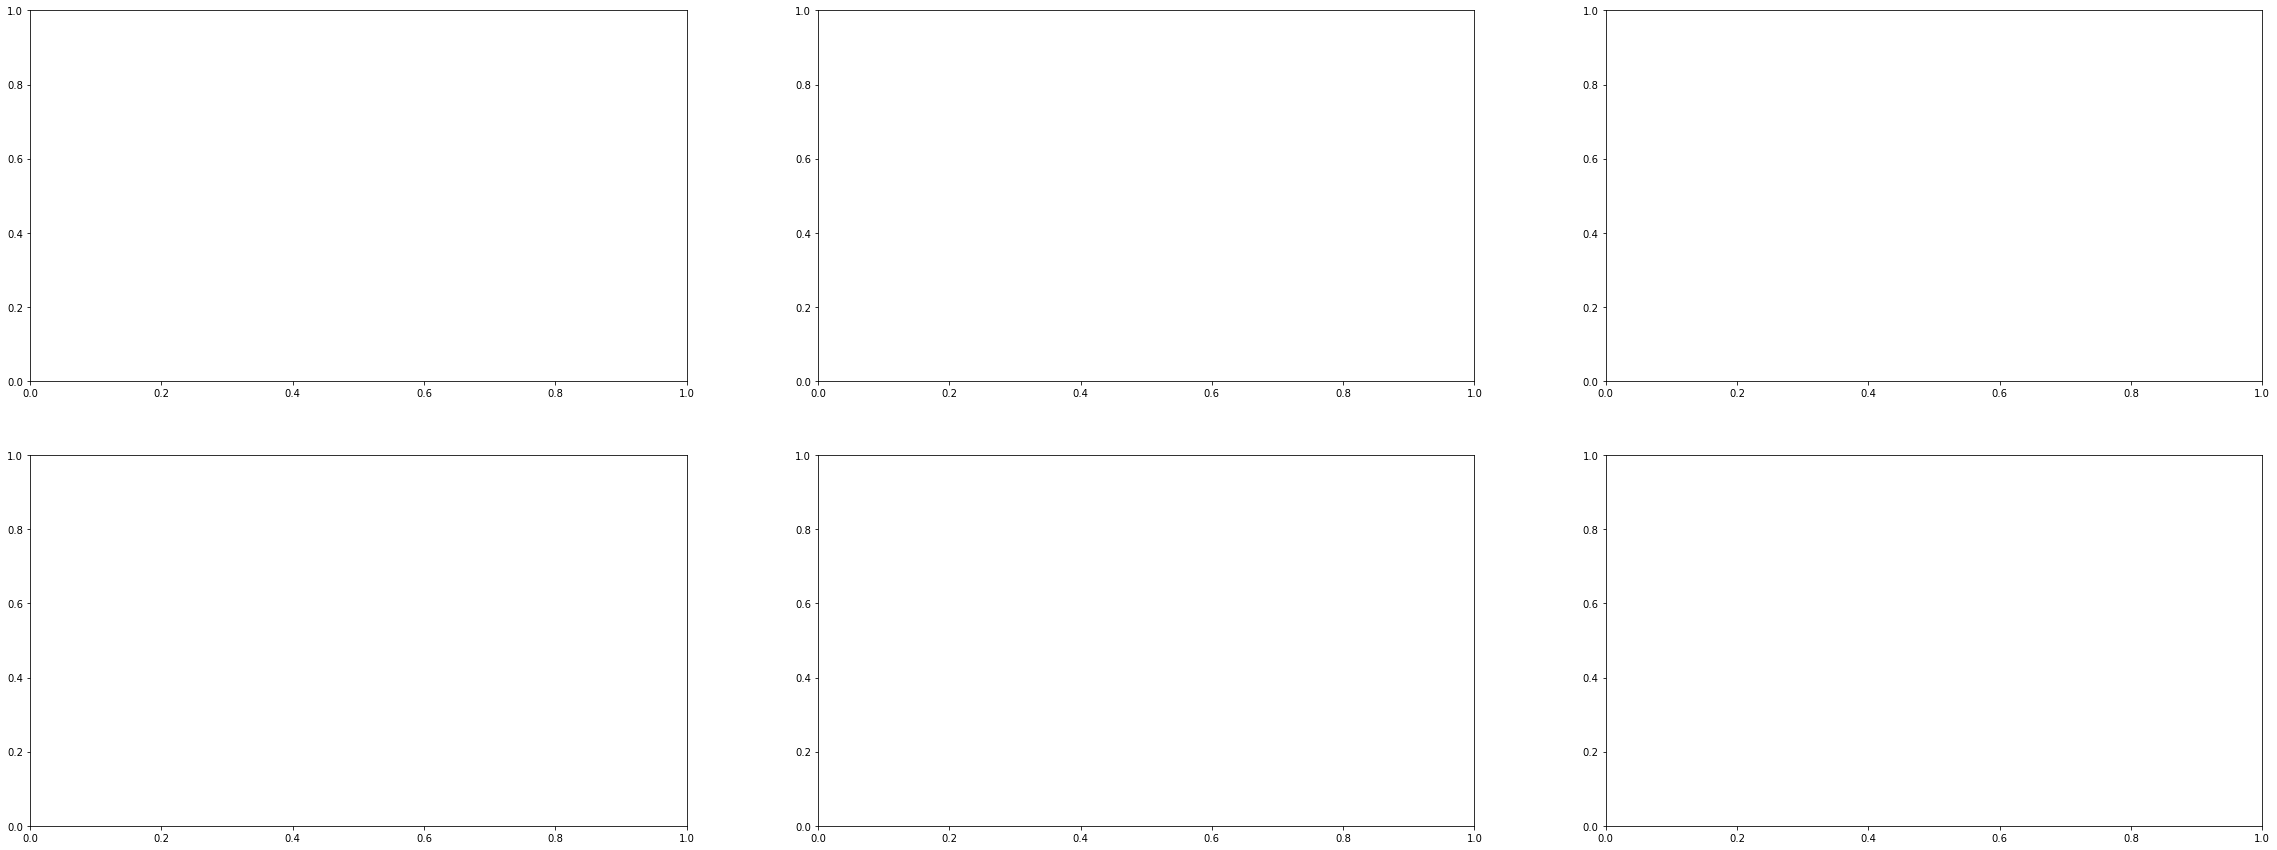

In [4]:
from video import TrackVideo
video = TrackVideo(gtx=None,gty=None)
video.generate("video/dynamic_150.avi", fps=3)

In [21]:
def errorPropagation2(R,Az,dR,dAz):
    J = np.array([[np.sin(Az), R*np.cos(Az)],[np.cos(Az), -R*np.sin(Az)]]) #x and y are opposite here!
    print("J",J)
    print(J.shape)
    orig_cov =  np.diag([dR*dR, dAz*dAz])

    return np.matmul(np.matmul(np.transpose(J, (2,0,1)), orig_cov), np.transpose(J, (2,1,0)))

cov = errorPropagation2(R=np.array([40]), Az=np.array([0]), dR=0.4, dAz=0.05)
print(cov)

J [[[ 0.]
  [40.]]

 [[ 1.]
  [-0.]]]
(2, 2, 1)
[[[4.   0.  ]
  [0.   0.16]]]


In [24]:
(np.sin(0.05)**2)*(0.4**2)+(40**2)*(np.cos(0.05)**2)*(0.05**2)

3.990407997333811

In [185]:
with open(r'C:\Users\gadli\Desktop\sensor2.txt', 'r') as f:
    lines = f.readlines()
    
s1_t0 = 1641063513926
s2_t0 = 1641063513941
start = s1_t0
step = 40
end = start + step * 1594
x = np.arange(start, end, step)
print(x.shape,len(lines))
lines = [str(x[i]) + " " + line for i,line in enumerate(lines)]
print(len(lines[45::25]))
with open(r'C:\Users\gadli\Desktop\sensor2_new.txt', 'w') as f:
    f.writelines(lines[20::25])

(1594,) 1594
62


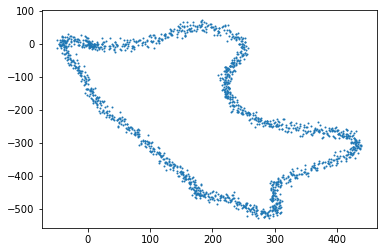

range(0, 1594)


In [45]:
import matplotlib.pyplot as plt
import numpy as np
with open(r'C:\Users\gadli\Desktop\SW Assignment Yann\data\sensor1_drive2.txt', 'r') as f:
    lines = f.readlines()
    
xy = [line.split() for line in lines]
xy = np.array(xy).astype(np.float32)
x = xy[:,0]
y = xy[:,1]

#x_noisy = x + np.random.normal(0,4,x.shape[0])
#y_noisy = y + np.random.normal(0,9,y.shape[0])

fig, ax = plt.subplots()
ax.scatter(x, y, s=1, label="GT")
ax.scatter(x, y, s=1, label="GT")
plt.show()
print(range(x.shape[0]))

#lines = [str(x_noisy[i]) + " " + str(y_noisy[i]) + "\n" for i in range(x.shape[0])]
#lines = [str(x[i]) + " " + str(y[i]) + "\n" for i in range(x.shape[0])]
#with open(r'C:\Users\gadli\Desktop\SW Assignment Yann\data\sensor2.txt', 'w') as f:
    #f.writelines(lines)


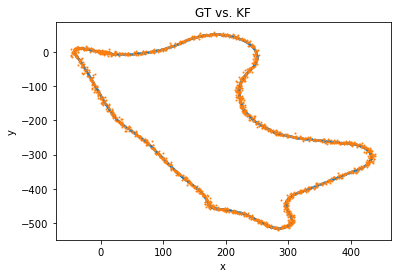

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import os

dir_path = r"C:\Users\gadli\Desktop\SW Assignment Yann\data"
with open(os.path.join(dir_path, 'sensor2.txt'), 'r') as f:
    gt_lines = f.readlines()
    
with open(os.path.join(dir_path, 'sensor1_drive1.txt'), 'r') as f:
    kf_lines = f.readlines()
    
xy = [line.split() for line in gt_lines]
xy = np.array(xy).astype(np.float32)
x_gt = xy[:,0]
y_gt = xy[:,1]
          
xy = [line.split() for line in kf_lines]
xy = np.array(xy).astype(np.float32)
x_kf = xy[:,0]
y_kf = xy[:,1]

fig, ax = plt.subplots()
ax.set_title("GT vs. KF")
ax.scatter(x_gt, y_gt, s=1, label="GT")
ax.scatter(x_kf, y_kf, s=1, label="KF")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()